In [1]:
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [2]:
import torch
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device:", torch.cuda.get_device_name(0))
else:
    print("No GPU detected.")



CUDA available: True
Device: NVIDIA GeForce RTX 3060 Laptop GPU


Dataset


In [6]:
import os
import shutil
import random

# Define paths
original_dir = 'raw-img'
base_dir = 'processed-img'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Create directories
for dir_path in [train_dir, val_dir, test_dir]:
    os.makedirs(dir_path, exist_ok=True)

# Split data
split_ratios = {'train': 0.7, 'val': 0.1, 'test': 0.2}
classes = os.listdir(original_dir)

for class_name in classes:
    class_dir = os.path.join(original_dir, class_name)
    images = os.listdir(class_dir)
    random.shuffle(images)

    train_cutoff = int(split_ratios['train'] * len(images))
    val_cutoff = train_cutoff + int(split_ratios['val'] * len(images))

    splits = {
        'train': images[:train_cutoff],
        'val': images[train_cutoff:val_cutoff],
        'test': images[val_cutoff:]
    }

    for split, image_list in splits.items():
        split_class_dir = os.path.join(base_dir, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)
        for image in image_list:
            src = os.path.join(class_dir, image)
            dst = os.path.join(split_class_dir, image)
            shutil.copy(src, dst)

print("Data successfully split into train, val, and test sets!")


Data successfully split into train, val, and test sets!


In [24]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

# Define directories for train, val, and test
train_dir = 'processed-img/train'
val_dir = 'processed-img/val'
test_dir = 'processed-img/test'

# Define image transformations without augmentation
basic_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a fixed size
    transforms.ToTensor(),         # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize (example: ImageNet normalization)
])

# Load the datasets
train_dataset2 = ImageFolder(root=train_dir, transform=basic_transforms)
val_dataset2 = ImageFolder(root=val_dir, transform=basic_transforms)
test_dataset2 = ImageFolder(root=test_dir, transform=basic_transforms)

# Create DataLoader for batching
train_loader2 = DataLoader(train_dataset2, batch_size=32, shuffle=True)
val_loader2 = DataLoader(val_dataset2, batch_size=32, shuffle=False)
test_loader2 = DataLoader(test_dataset2, batch_size=32, shuffle=False)

# Get class labels
class_labels = train_dataset2.classes  # List of class names (subfolder names)

# Print class labels
print("Class Labels:", class_labels)

# To check if everything works fine, you can print the size of batches and corresponding labels
for images, labels in train_loader2:
    print("Images size:", images.size())  # Images: (batch_size, channels, height, width)
    print("Labels (batch):", labels)  # Labels: (batch_size)
    # Convert numeric labels to class names
    label_names = [class_labels[label] for label in labels]
    print("Label Names (batch):", label_names)  # Corresponding class names
    break  # Print only the first batch


Class Labels: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Images size: torch.Size([32, 3, 224, 224])
Labels (batch): tensor([9, 8, 8, 3, 8, 2, 9, 0, 0, 3, 9, 8, 0, 6, 3, 8, 8, 0, 0, 0, 8, 6, 0, 8,
        8, 0, 7, 8, 3, 0, 8, 7])
Label Names (batch): ['scoiattolo', 'ragno', 'ragno', 'farfalla', 'ragno', 'elefante', 'scoiattolo', 'cane', 'cane', 'farfalla', 'scoiattolo', 'ragno', 'cane', 'mucca', 'farfalla', 'ragno', 'ragno', 'cane', 'cane', 'cane', 'ragno', 'mucca', 'cane', 'ragno', 'ragno', 'cane', 'pecora', 'ragno', 'farfalla', 'cane', 'ragno', 'pecora']


In [28]:


# Define directories for train, val, and test
train_dir = 'processed-img/train'
val_dir = 'processed-img/val'
test_dir = 'processed-img/test'

# Define image transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, translate=None, scale=(0.8, 1.2), shear=None),  # Zoom via scaling
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Example for ImageNet normalization
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Example for ImageNet normalization
])

# Load the datasets
train_dataset = ImageFolder(root=train_dir, transform=train_transforms)
val_dataset = ImageFolder(root=val_dir, transform=val_test_transforms)
test_dataset = ImageFolder(root=test_dir, transform=val_test_transforms)

# Create DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Get class labels
class_labels = train_dataset.classes  # List of class names (subfolder names)

# Print class labels
print("Class Labels:", class_labels)

# To check if everything works fine, you can print the size of batches and corresponding labels
for images, labels in train_loader:
    print("Images size:", images.size())  # Images: (batch_size, channels, height, width)
    print("Labels (batch):", labels)  # Labels: (batch_size)
    # Convert numeric labels to class names
    label_names = [class_labels[label] for label in labels]
    print("Label Names (batch):", label_names)  # Corresponding class names
    break  # Print only the first batch


Class Labels: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Images size: torch.Size([32, 3, 224, 224])
Labels (batch): tensor([4, 4, 8, 8, 8, 1, 9, 9, 4, 5, 3, 9, 5, 0, 0, 7, 8, 8, 5, 8, 8, 0, 4, 8,
        0, 4, 6, 3, 0, 0, 0, 5])
Label Names (batch): ['gallina', 'gallina', 'ragno', 'ragno', 'ragno', 'cavallo', 'scoiattolo', 'scoiattolo', 'gallina', 'gatto', 'farfalla', 'scoiattolo', 'gatto', 'cane', 'cane', 'pecora', 'ragno', 'ragno', 'gatto', 'ragno', 'ragno', 'cane', 'gallina', 'ragno', 'cane', 'gallina', 'mucca', 'farfalla', 'cane', 'cane', 'cane', 'gatto']


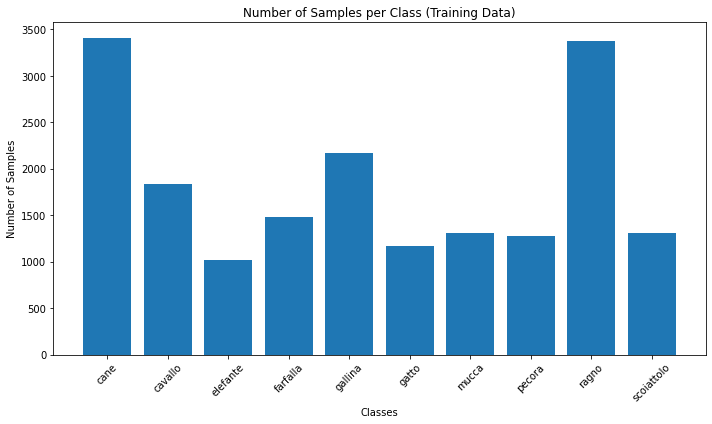

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Compute the number of samples per class in the training set
class_counts = Counter()

for _, labels in train_loader:
    class_counts.update(labels.numpy())  # Update counts for each class label

# Prepare the counts for plotting
train_class_counts = [class_counts[i] for i in range(len(class_labels))]

# Plot the number of samples per class
x = np.arange(len(class_labels))

plt.figure(figsize=(10, 6))
plt.bar(x, train_class_counts)

# Add class labels to the x-axis
plt.xticks(x, class_labels, rotation=45)
plt.xlabel("Classes")
plt.ylabel("Number of Samples")
plt.title("Number of Samples per Class (Training Data)")
plt.tight_layout()
plt.show()


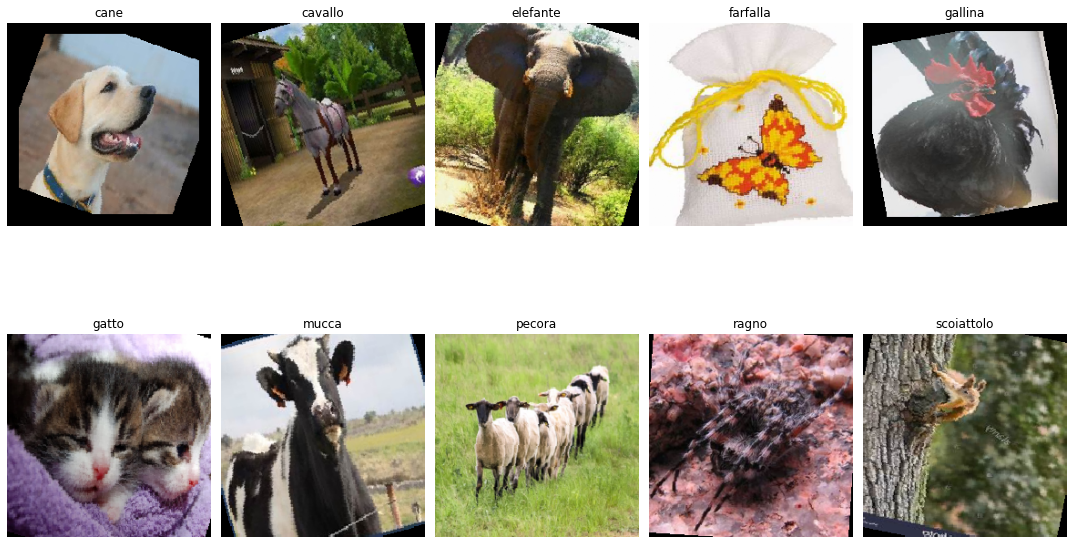

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Get the class names from the dataset
classes = train_dataset.classes

# Create a dictionary to track whether we have already displayed one image per class
displayed_classes = {class_name: False for class_name in classes}

# Initialize a plot for the images
plt.figure(figsize=(15, 10))

# Reverse normalization (if you used ImageNet stats or similar normalization)
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

# Function to unnormalize the image
def unnormalize(img, mean, std):
    # Denormalize the image
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    return img

# Iterate through the batches in the train loader until all classes are covered
for images, labels in train_loader:
    # Iterate through images and labels in the current batch
    for img, label in zip(images, labels):
        class_idx = label.item()  # Get the class index of the current image
        class_name = classes[class_idx]
        
        # If we haven't displayed an image for this class yet
        if not displayed_classes[class_name]:
            # Unnormalize the image and convert from CxHxW to HxWxC for matplotlib
            img = unnormalize(img, mean, std).permute(1, 2, 0).cpu().numpy()  # Convert to HxWxC format

            # Plot the image
            plt.subplot(2, 5, list(displayed_classes.keys()).index(class_name) + 1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis('off')
            displayed_classes[class_name] = True  # Mark the class as displayed

        # Break out of the loop if all classes have been displayed
        if all(displayed_classes.values()):
            break
    if all(displayed_classes.values()):
        break

plt.tight_layout()
plt.show()


Phase1

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(128)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(256)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)  # Global Average Pooling
        self.fc1 = nn.Linear(256, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.maxpool2(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.maxpool3(x)
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.maxpool4(x)
        
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Instantiate the model
model = CNNModel(num_classes=10)

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Print model summary (similar to Keras model summary)
print(model)

# Print model summary and check parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total Parameters: {total_params}")


CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (global_avg_pool): AdaptiveA

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


# Define the CNN model
class CNNModel2(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNModel2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)  # Global Average Pooling
        self.fc1 = nn.Linear(256, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        
        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)
        
        x = F.relu(self.conv3(x))
        x = self.maxpool3(x)
        
        x = F.relu(self.conv4(x))
        x = self.maxpool4(x)
        
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = CNNModel2(num_classes=10)

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Print model summary (similar to Keras model summary)
print(model)

# Print model summary and check parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total Parameters: {total_params}")


CNNModel2(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (global_avg_pool): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=256, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)
Total Parameters: 525130


Over_Fit


In [ ]:
from torchmetrics.classification import MulticlassAccuracy
from torch.utils.data import DataLoader

# Hyperparameters
learning_rate = 0.001
batch_size = 32
epochs = 25
num_classes = 10  # Number of classes in your dataset

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Accuracy metric
accuracy_metric = MulticlassAccuracy(num_classes=num_classes).to(device)

# DataLoaders for training and validation datasets
train_loader = DataLoader(train_dataset2, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset2, batch_size=batch_size, shuffle=False)

# Move the model to the appropriate device
model = model.to(device)

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Training phase
    for images, labels in train_loader:
        # Move data to GPU if available
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%")

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            # Move data to GPU if available
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%")


Using device: cuda
Epoch [1/25], Loss: 2.1344, Accuracy: 21.85%
Validation Loss: 1.9365, Validation Accuracy: 31.83%
Epoch [2/25], Loss: 1.7537, Accuracy: 38.23%
Validation Loss: 1.6133, Validation Accuracy: 42.31%
Epoch [3/25], Loss: 1.4600, Accuracy: 48.56%
Validation Loss: 1.3477, Validation Accuracy: 51.19%
Epoch [4/25], Loss: 1.2985, Accuracy: 54.39%
Validation Loss: 1.2531, Validation Accuracy: 55.51%
Epoch [5/25], Loss: 1.1671, Accuracy: 59.40%
Validation Loss: 1.1724, Validation Accuracy: 58.65%
Epoch [6/25], Loss: 1.0645, Accuracy: 62.98%
Validation Loss: 1.0765, Validation Accuracy: 62.43%
Epoch [7/25], Loss: 0.9816, Accuracy: 65.97%
Validation Loss: 0.9988, Validation Accuracy: 65.76%
Epoch [8/25], Loss: 0.9067, Accuracy: 68.76%
Validation Loss: 0.9782, Validation Accuracy: 65.80%
Epoch [9/25], Loss: 0.8487, Accuracy: 70.67%
Validation Loss: 0.9321, Validation Accuracy: 67.56%
Epoch [10/25], Loss: 0.7876, Accuracy: 72.75%
Validation Loss: 0.8926, Validation Accuracy: 69.20%


In [18]:
# Save the entire model using pickle
model_save_path = "over_fitted_model.pkl"
with open(model_save_path, 'wb') as f:
    pickle.dump(model, f)

print(f"Model pickled and saved to {model_save_path}")

Model pickled and saved to over_fitted_model.pkl


In [10]:
# Load the pickled model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model_save_path = "over_fitted_model.pkl"
with open(model_save_path, 'rb') as f:
    loaded_model = pickle.load(f)

loaded_model = loaded_model.to(device)  # Move the model to the appropriate device
print("Model loaded successfully!")

Using device: cuda
Model loaded successfully!


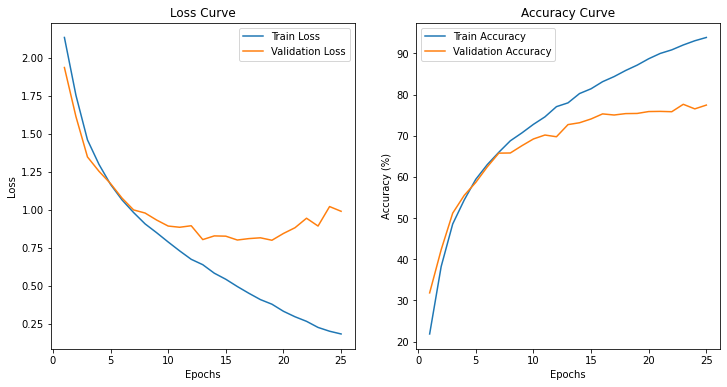

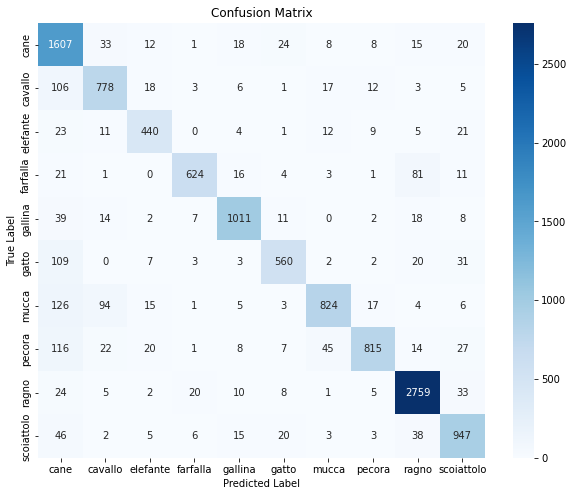

Precision: 0.8746, Recall: 0.8671, F1 Score: 0.8671
Test Accuracy: 86.71%


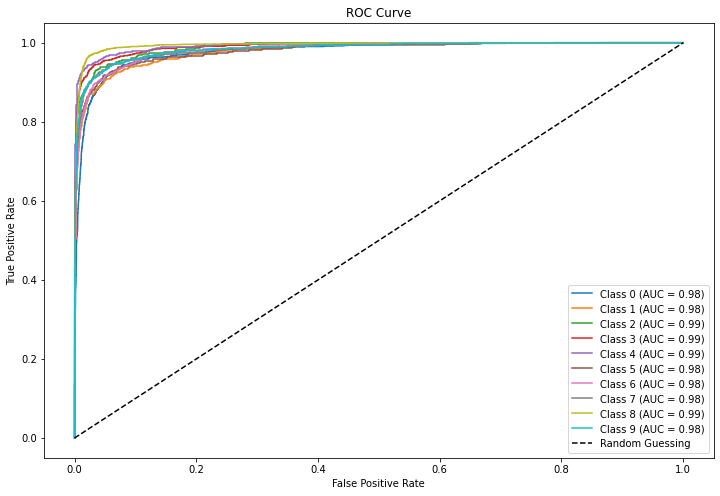

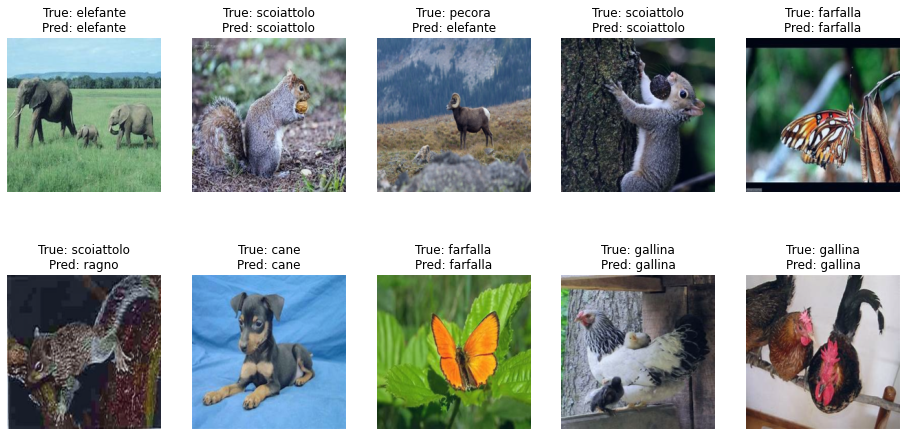

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc, precision_recall_fscore_support
)
from torch.utils.data import DataLoader
import numpy as np
model = loaded_model
# Initialize lists for storing training and validation metrics
train_losses = [
    2.1344, 1.7537, 1.4600, 1.2985, 1.1671, 
    1.0645, 0.9816, 0.9067, 0.8487, 0.7876, 
    0.7288, 0.6735, 0.6382, 0.5822, 0.5421, 
    0.4943, 0.4499, 0.4083, 0.3780, 0.3313, 
    0.2953, 0.2652, 0.2250, 0.2000, 0.1819
]

val_losses = [
    1.9365, 1.6133, 1.3477, 1.2531, 1.1724, 
    1.0765, 0.9988, 0.9782, 0.9321, 0.8926, 
    0.8846, 0.8946, 0.8034, 0.8277, 0.8259, 
    0.8006, 0.8099, 0.8152, 0.7991, 0.8438, 
    0.8815, 0.9441, 0.8926, 1.0209, 0.9898
]

train_accuracies = [
    21.85, 38.23, 48.56, 54.39, 59.40, 
    62.98, 65.97, 68.76, 70.67, 72.75, 
    74.57, 77.05, 77.97, 80.23, 81.39, 
    83.11, 84.35, 85.83, 87.13, 88.68, 
    89.97, 90.84, 92.03, 93.05, 93.85
]

val_accuracies = [
    31.83, 42.31, 51.19, 55.51, 58.65, 
    62.43, 65.76, 65.80, 67.56, 69.20, 
    70.16, 69.74, 72.69, 73.14, 74.06, 
    75.29, 75.02, 75.36, 75.40, 75.86, 
    75.90, 75.82, 77.62, 76.51, 77.43
]

class_names = class_labels

# Test DataLoader
test_loader = DataLoader(test_dataset2, batch_size=32, shuffle=False)

# After training, plot learning curves and evaluate the model
def evaluate_and_plot_metrics(model, train_losses, val_losses, train_accuracies, val_accuracies):
    # Plot learning curves
    epochs_range = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label="Train Loss")
    plt.plot(epochs_range, val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
    plt.plot(epochs_range, val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy Curve")
    plt.legend()

    plt.show()

# Function to evaluate the model on test data and generate metrics
def evaluate_on_test_data(model, test_loader):
    model.eval()
    y_true, y_pred, y_probs = [], [], []
    correct = 0  # Initialize correct predictions counter
    total = 0  # Initialize total samples counter

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_probs.extend(probabilities.cpu().numpy())

            # Count correct predictions and total samples
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # Calculate test accuracy
    test_accuracy = 100 * correct / total

    # Generate Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # Print classification report
    precision, recall, f1_score, _ = precision_recall_fscore_support(
        y_true, y_pred, average="weighted"
    )
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")  # Print test accuracy

    # Generate and plot ROC curve for each class
    plt.figure(figsize=(12, 8))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(
            [1 if label == i else 0 for label in y_true],
            [prob[i] for prob in y_probs]
        )
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], "k--", label="Random Guessing")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()


import random

# Visualize some random test images with predictions and true labels
def visualize_predictions(model, test_loader, num_images=10):
    model.eval()

    # Collect all images and labels from the test loader
    all_images, all_labels = [], []
    for images, labels in test_loader:
        all_images.append(images)
        all_labels.append(labels)

    # Concatenate all batches into single tensors
    all_images = torch.cat(all_images)
    all_labels = torch.cat(all_labels)

    # Generate random indices for selecting images
    random_indices = random.sample(range(len(all_images)), min(num_images, len(all_images)))

    # Select random images and labels
    selected_images = all_images[random_indices]
    selected_labels = all_labels[random_indices]

    with torch.no_grad():
        outputs = model(selected_images.to(device))
        _, predictions = torch.max(outputs, 1)

    plt.figure(figsize=(16, 8))
    for i, idx in enumerate(random_indices):
        # Convert the tensor image to numpy and rescale pixel values to [0, 1]
        img = selected_images[i].cpu().numpy()
        img = np.transpose(img, (1, 2, 0))  # Convert from [C, H, W] to [H, W, C]
        img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]

        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.title(
            f"True: {class_names[selected_labels[i]]}\nPred: {class_names[predictions[i].cpu()]}"
        )
        plt.axis("off")
    plt.show()


# Call the functions
evaluate_and_plot_metrics(model, train_losses, val_losses, train_accuracies, val_accuracies)
evaluate_on_test_data(model, test_loader)
visualize_predictions(model, test_loader)


Phase 2

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the optimized CNN model
class OptimizedCNNModel(nn.Module):
    def __init__(self, num_classes=10):
        super(OptimizedCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)  # Reduced channels
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)  # Reduced channels
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)  # Reduced channels
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)  # Reduced channels
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)

        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)  # Global Average Pooling
        self.fc1 = nn.Linear(128, 256)  # Reduced size
        self.fc2 = nn.Linear(256, num_classes)  # Output layer

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)

        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)

        x = F.relu(self.conv3(x))
        x = self.maxpool3(x)

        x = F.relu(self.conv4(x))
        x = self.maxpool4(x)

        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the optimized model
optimized_model = OptimizedCNNModel(num_classes=10)

# Print the optimized model
print(optimized_model)

# Calculate total trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(optimized_model)
print(f"Total Parameters: {total_params}")


OptimizedCNNModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (global_avg_pool): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)
Total Parameters: 133034


In [24]:
from torchmetrics.classification import MulticlassAccuracy
from torch.utils.data import DataLoader

# Hyperparameters
learning_rate = 0.001
batch_size = 32
epochs = 25
num_classes = 10  # Number of classes in your dataset
model = optimized_model
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Accuracy metric
accuracy_metric = MulticlassAccuracy(num_classes=num_classes).to(device)

# DataLoaders for training and validation datasets
train_loader = DataLoader(train_dataset2, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset2, batch_size=batch_size, shuffle=False)

# Move the model to the appropriate device
model = model.to(device)

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Training phase
    for images, labels in train_loader:
        # Move data to GPU if available
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%")

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            # Move data to GPU if available
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%")


Using device: cuda
Epoch [1/25], Loss: 2.0896, Accuracy: 24.06%
Validation Loss: 1.9105, Validation Accuracy: 30.49%
Epoch [2/25], Loss: 1.7630, Accuracy: 37.77%
Validation Loss: 1.6337, Validation Accuracy: 40.78%
Epoch [3/25], Loss: 1.5127, Accuracy: 46.50%
Validation Loss: 1.4231, Validation Accuracy: 48.85%
Epoch [4/25], Loss: 1.3688, Accuracy: 51.69%
Validation Loss: 1.3306, Validation Accuracy: 51.53%
Epoch [5/25], Loss: 1.2896, Accuracy: 55.02%
Validation Loss: 1.3047, Validation Accuracy: 53.56%
Epoch [6/25], Loss: 1.2046, Accuracy: 58.19%
Validation Loss: 1.1961, Validation Accuracy: 57.08%
Epoch [7/25], Loss: 1.1289, Accuracy: 60.71%
Validation Loss: 1.1321, Validation Accuracy: 59.53%
Epoch [8/25], Loss: 1.0645, Accuracy: 62.74%
Validation Loss: 1.1450, Validation Accuracy: 60.41%
Epoch [9/25], Loss: 1.0050, Accuracy: 64.83%
Validation Loss: 1.0591, Validation Accuracy: 62.59%
Epoch [10/25], Loss: 0.9548, Accuracy: 66.70%
Validation Loss: 0.9909, Validation Accuracy: 64.96%


In [25]:
# Continue training the model for 15 more epochs
additional_epochs = 15

for epoch in range(epochs, epochs + additional_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Training phase
    for images, labels in train_loader:
        # Move data to GPU if available
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{epochs + additional_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%")

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            # Move data to GPU if available
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%")


Epoch [26/40], Loss: 0.4465, Accuracy: 84.61%
Validation Loss: 0.8425, Validation Accuracy: 74.22%
Epoch [27/40], Loss: 0.4113, Accuracy: 86.07%
Validation Loss: 0.8515, Validation Accuracy: 74.02%
Epoch [28/40], Loss: 0.3867, Accuracy: 86.71%
Validation Loss: 0.8684, Validation Accuracy: 75.44%
Epoch [29/40], Loss: 0.3684, Accuracy: 87.47%
Validation Loss: 0.9038, Validation Accuracy: 73.68%
Epoch [30/40], Loss: 0.3531, Accuracy: 87.77%
Validation Loss: 0.8514, Validation Accuracy: 74.90%
Epoch [31/40], Loss: 0.3236, Accuracy: 88.92%
Validation Loss: 0.8382, Validation Accuracy: 75.59%
Epoch [32/40], Loss: 0.3007, Accuracy: 89.74%
Validation Loss: 0.8593, Validation Accuracy: 76.43%
Epoch [33/40], Loss: 0.2934, Accuracy: 89.83%
Validation Loss: 0.8903, Validation Accuracy: 75.02%
Epoch [34/40], Loss: 0.2723, Accuracy: 90.69%
Validation Loss: 0.8580, Validation Accuracy: 77.12%
Epoch [35/40], Loss: 0.2377, Accuracy: 91.93%
Validation Loss: 0.9407, Validation Accuracy: 76.59%
Epoch [36/

In [28]:
# Save the entire model using pickle
model_save_path = "over_fitted_model_less_params.pkl"
with open(model_save_path, 'wb') as f:
    pickle.dump(model, f)

print(f"Model pickled and saved to {model_save_path}")

Model pickled and saved to over_fitted_model_less_params.pkl


In [29]:
# Load the pickled model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model_save_path = "over_fitted_model_less_params.pkl"
with open(model_save_path, 'rb') as f:
    loaded_model = pickle.load(f)

loaded_model = loaded_model.to(device)  # Move the model to the appropriate device
print("Model loaded successfully!")

Using device: cuda
Model loaded successfully!


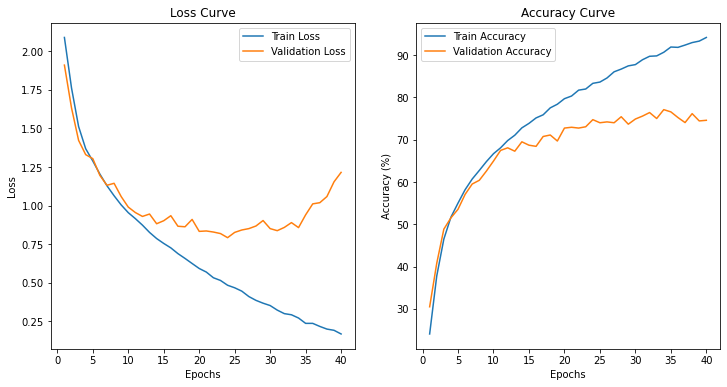

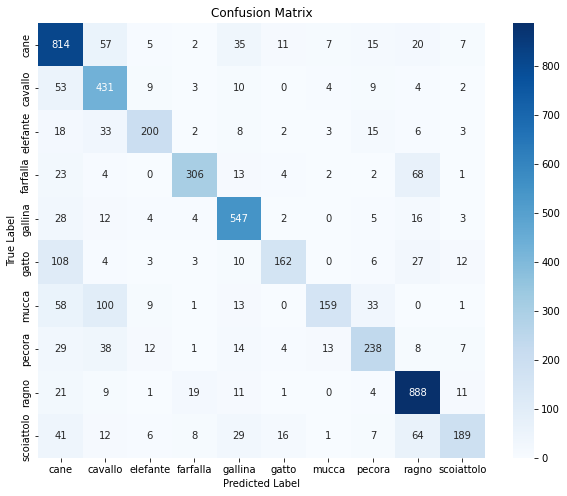

Precision: 0.7635, Recall: 0.7503, F1 Score: 0.7424
Test Accuracy: 75.03%


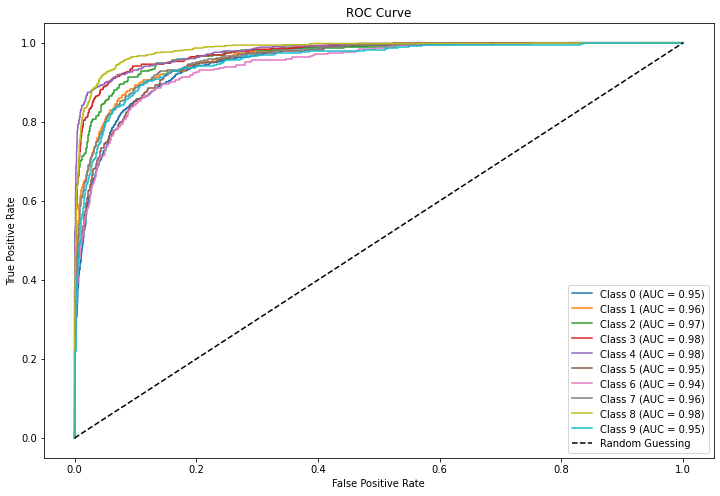

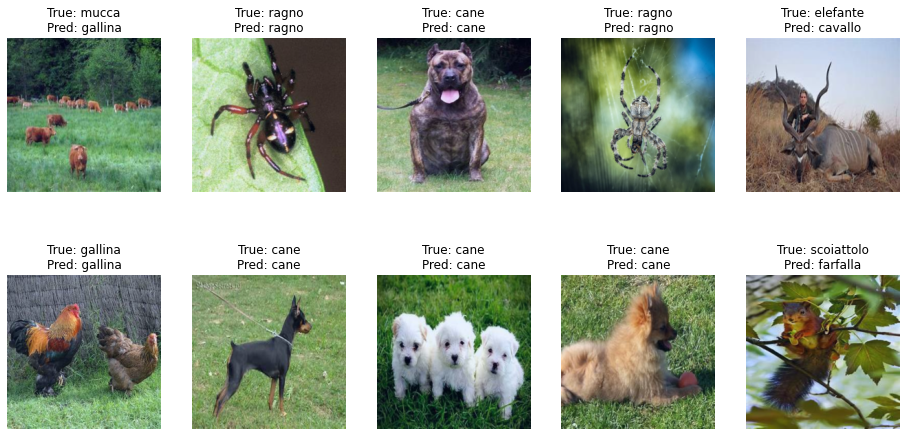

In [30]:
model = loaded_model
# Initialize lists for storing training and validation metrics
train_losses = [
    2.0896, 1.7630, 1.5127, 1.3688, 1.2896, 1.2046, 1.1289, 1.0645, 1.0050, 0.9548,
    0.9161, 0.8740, 0.8268, 0.7871, 0.7554, 0.7267, 0.6895, 0.6583, 0.6255, 0.5932,
    0.5701, 0.5332, 0.5157, 0.4846, 0.4682, 0.4465, 0.4113, 0.3867, 0.3684, 0.3531,
    0.3236, 0.3007, 0.2934, 0.2723, 0.2377, 0.2377, 0.2179, 0.2007, 0.1928, 0.1690
]

val_losses = [
    1.9105, 1.6337, 1.4231, 1.3306, 1.3047, 1.1961, 1.1321, 1.1450, 1.0591, 0.9909,
    0.9556, 0.9304, 0.9459, 0.8830, 0.9026, 0.9351, 0.8668, 0.8634, 0.9110, 0.8336,
    0.8362, 0.8293, 0.8194, 0.7928, 0.8270, 0.8425, 0.8515, 0.8684, 0.9038, 0.8514,
    0.8382, 0.8593, 0.8903, 0.8580, 0.9407, 1.0117, 1.0194, 1.0591, 1.1544, 1.2157
]

train_accuracies = [
    24.06, 37.77, 46.50, 51.69, 55.02, 58.19, 60.71, 62.74, 64.83, 66.70,
    68.09, 69.81, 71.07, 72.81, 73.87, 75.16, 75.90, 77.54, 78.40, 79.71,
    80.34, 81.73, 82.00, 83.34, 83.64, 84.61, 86.07, 86.71, 87.47, 87.77,
    88.92, 89.74, 89.83, 90.69, 91.93, 91.85, 92.39, 92.98, 93.33, 94.19
]

val_accuracies = [
    30.49, 40.78, 48.85, 51.53, 53.56, 57.08, 59.53, 60.41, 62.59, 64.96,
    67.48, 68.09, 67.29, 69.51, 68.71, 68.44, 70.77, 71.12, 69.70, 72.76,
    72.95, 72.76, 73.07, 74.75, 74.02, 74.22, 74.02, 75.44, 73.68, 74.90,
    75.59, 76.43, 75.02, 77.12, 76.59, 75.25, 74.06, 76.17, 74.45, 74.60
]


class_names = class_labels

# Test DataLoader
test_loader = DataLoader(test_dataset2, batch_size=32, shuffle=False)
# Call the functions
evaluate_and_plot_metrics(model, train_losses, val_losses, train_accuracies, val_accuracies)
evaluate_on_test_data(model, test_loader)
visualize_predictions(model, test_loader)

Phase 3

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.batchnorm1 = nn.BatchNorm2d(32)  # Batch normalization after conv1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.batchnorm2 = nn.BatchNorm2d(64)  # Batch normalization after conv2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.batchnorm3 = nn.BatchNorm2d(128)  # Batch normalization after conv3
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        self.batchnorm4 = nn.BatchNorm2d(256)  # Batch normalization after conv4
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)  # Global Average Pooling
        self.fc1 = nn.Linear(256, 512)
        self.dropout1 = nn.Dropout(0.5)  # Dropout after first fully connected layer
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.batchnorm1(self.conv1(x)))  # Batch norm before activation
        x = self.maxpool1(x)
        
        x = F.relu(self.batchnorm2(self.conv2(x)))  # Batch norm before activation
        x = self.maxpool2(x)
        
        x = F.relu(self.batchnorm3(self.conv3(x)))  # Batch norm before activation
        x = self.maxpool3(x)
        
        x = F.relu(self.batchnorm4(self.conv4(x)))  # Batch norm before activation
        x = self.maxpool4(x)
        
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)  # Apply dropout during training
        x = self.fc2(x)
        return x

# Instantiate the model
model = CNNModel(num_classes=10)

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Print model summary (similar to Keras model summary)
print(model)

# Print model summary and check parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total Parameters: {total_params}")


CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics.classification import MulticlassAccuracy
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset

torch.cuda.empty_cache()
del model

# Hyperparameters
learning_rate = 0.002
batch_size = 32
epochs = 25
num_classes = 10  # Number of classes in your dataset
model = optimized_model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)  # L2 Regularization (weight decay)

# Learning Rate Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

# Accuracy metric
accuracy_metric = MulticlassAccuracy(num_classes=num_classes).to(device)

# # Data Augmentation (train data only)
# train_transforms = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(10),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
#     transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
#     transforms.ToTensor(),
# ])

# # For validation, just normalization (no augmentation)
# val_transforms = transforms.Compose([
#     transforms.ToTensor(),
# ])

# # Apply transformations to the datasets
# train_dataset2_transformed = train_dataset2  # Apply transform to your dataset here
# val_dataset2_transformed = val_dataset2  # Apply transform to your dataset here

# # Assuming you have a custom dataset class that allows the use of transforms
# train_dataset2_transformed.transform = train_transforms
# val_dataset2_transformed.transform = val_transforms

# DataLoaders for training and validation datasets with transformations
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Move the model to the appropriate device
model = model.to(device)

# Early stopping variables
best_val_loss = float('inf')
patience = 5
trigger_times = 0

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Training phase
    for images, labels in train_loader:
        # Move data to GPU if available
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%")

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            # Move data to GPU if available
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0  # Reset the counter when the validation loss improves
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered!")
            break

    # Step the scheduler (adjust learning rate)
    scheduler.step(val_loss)


Using device: cuda
Epoch [1/25], Loss: 0.6704, Accuracy: 77.14%
Validation Loss: 0.7603, Validation Accuracy: 75.71%
Epoch [2/25], Loss: 0.6428, Accuracy: 78.46%
Validation Loss: 0.7274, Validation Accuracy: 76.17%
Epoch [3/25], Loss: 0.6212, Accuracy: 79.15%
Validation Loss: 0.7494, Validation Accuracy: 75.06%
Epoch [4/25], Loss: 0.6147, Accuracy: 79.55%
Validation Loss: 0.7839, Validation Accuracy: 74.37%
Epoch [5/25], Loss: 0.6045, Accuracy: 79.52%
Validation Loss: 0.7050, Validation Accuracy: 77.31%
Epoch [6/25], Loss: 0.5956, Accuracy: 79.89%
Validation Loss: 0.6849, Validation Accuracy: 77.16%
Epoch [7/25], Loss: 0.5857, Accuracy: 80.41%
Validation Loss: 0.6766, Validation Accuracy: 77.39%
Epoch [8/25], Loss: 0.5763, Accuracy: 80.77%
Validation Loss: 0.6934, Validation Accuracy: 77.58%
Epoch [9/25], Loss: 0.5675, Accuracy: 81.01%
Validation Loss: 0.6989, Validation Accuracy: 76.59%
Epoch [10/25], Loss: 0.5682, Accuracy: 80.64%
Validation Loss: 0.7259, Validation Accuracy: 76.82%


In [40]:
from torchmetrics.classification import MulticlassAccuracy
from torch.utils.data import DataLoader

# Hyperparameters
learning_rate = 0.001
batch_size = 32
epochs = 25
num_classes = 10  # Number of classes in your dataset

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Accuracy metric
accuracy_metric = MulticlassAccuracy(num_classes=num_classes).to(device)

# DataLoaders for training and validation datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Move the model to the appropriate device
model = model.to(device)

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Training phase
    for images, labels in train_loader:
        # Move data to GPU if available
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%")

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            # Move data to GPU if available
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%")


Using device: cuda
Epoch [1/25], Loss: 1.8797, Accuracy: 33.50%
Validation Loss: 1.6668, Validation Accuracy: 41.43%
Epoch [2/25], Loss: 1.6027, Accuracy: 43.77%
Validation Loss: 1.5604, Validation Accuracy: 44.53%
Epoch [3/25], Loss: 1.4549, Accuracy: 49.18%
Validation Loss: 1.5633, Validation Accuracy: 46.86%
Epoch [4/25], Loss: 1.3499, Accuracy: 52.46%
Validation Loss: 1.4254, Validation Accuracy: 50.61%
Epoch [5/25], Loss: 1.2870, Accuracy: 55.03%
Validation Loss: 1.2266, Validation Accuracy: 57.73%
Epoch [6/25], Loss: 1.2214, Accuracy: 57.25%
Validation Loss: 1.0851, Validation Accuracy: 62.62%
Epoch [7/25], Loss: 1.1760, Accuracy: 59.45%
Validation Loss: 1.0824, Validation Accuracy: 61.29%
Epoch [8/25], Loss: 1.1289, Accuracy: 61.12%
Validation Loss: 1.1398, Validation Accuracy: 59.49%
Epoch [9/25], Loss: 1.0931, Accuracy: 62.41%
Validation Loss: 1.0484, Validation Accuracy: 63.39%
Epoch [10/25], Loss: 1.0660, Accuracy: 63.31%
Validation Loss: 1.1100, Validation Accuracy: 60.21%


In [38]:
from torchmetrics.classification import MulticlassAccuracy
from torch.utils.data import DataLoader


# torch.cuda.empty_cache()
# del model

model = CNNModel(num_classes=10)
# Hyperparameters
learning_rate = 0.005
batch_size = 64
epochs = 40
num_classes = 10  # Number of classes in your dataset

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Accuracy metric
accuracy_metric = MulticlassAccuracy(num_classes=num_classes).to(device)

# DataLoaders for training and validation datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Move the model to the appropriate device
model = model.to(device)

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Training phase
    for images, labels in train_loader:
        # Move data to GPU if available
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%")

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            # Move data to GPU if available
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%")

Using device: cuda
Epoch [1/40], Loss: 2.0358, Accuracy: 27.16%
Validation Loss: 1.8617, Validation Accuracy: 35.50%
Epoch [2/40], Loss: 1.8447, Accuracy: 35.91%
Validation Loss: 1.7670, Validation Accuracy: 36.57%
Epoch [3/40], Loss: 1.6973, Accuracy: 40.83%
Validation Loss: 1.5121, Validation Accuracy: 46.44%
Epoch [4/40], Loss: 1.5324, Accuracy: 46.51%
Validation Loss: 1.4064, Validation Accuracy: 50.42%
Epoch [5/40], Loss: 1.4040, Accuracy: 51.55%
Validation Loss: 1.3755, Validation Accuracy: 50.84%
Epoch [6/40], Loss: 1.3136, Accuracy: 54.53%
Validation Loss: 1.3434, Validation Accuracy: 53.44%
Epoch [7/40], Loss: 1.2383, Accuracy: 57.37%
Validation Loss: 1.1597, Validation Accuracy: 59.22%
Epoch [8/40], Loss: 1.1773, Accuracy: 59.74%
Validation Loss: 1.1052, Validation Accuracy: 61.48%
Epoch [9/40], Loss: 1.1106, Accuracy: 62.42%
Validation Loss: 1.0605, Validation Accuracy: 62.09%
Epoch [10/40], Loss: 1.0776, Accuracy: 63.40%
Validation Loss: 1.0902, Validation Accuracy: 61.94%


In [39]:
# Save the entire model using pickle
model_save_path = "fit_model_of_phase1.pkl"
with open(model_save_path, 'wb') as f:
    pickle.dump(model, f)

print(f"Model pickled and saved to {model_save_path}")

Model pickled and saved to fit_model_of_phase1.pkl


In [29]:
# Load the pickled model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model_save_path = "fit_model_of_phase1.pkl"
with open(model_save_path, 'rb') as f:
    loaded_model = pickle.load(f)

loaded_model = loaded_model.to(device)  # Move the model to the appropriate device
print("Model loaded successfully!")
# print(loaded_model)

Using device: cuda
Model loaded successfully!


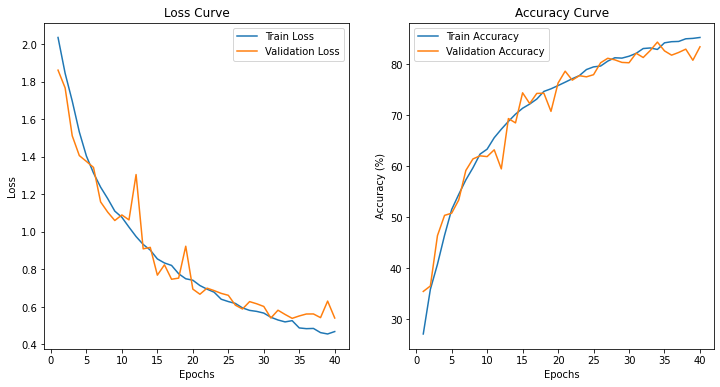

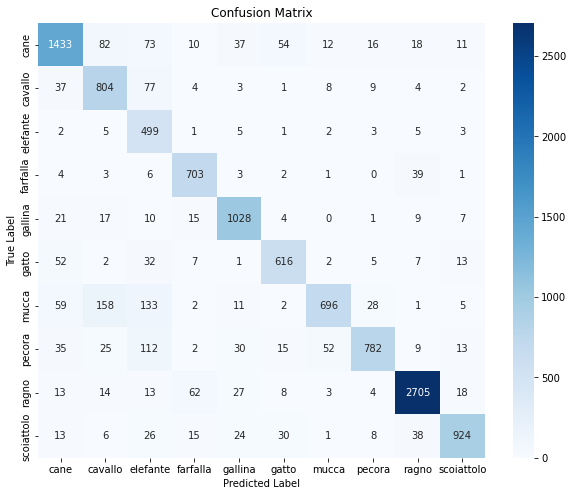

Precision: 0.8703, Recall: 0.8524, F1 Score: 0.8547
Test Accuracy: 85.24%


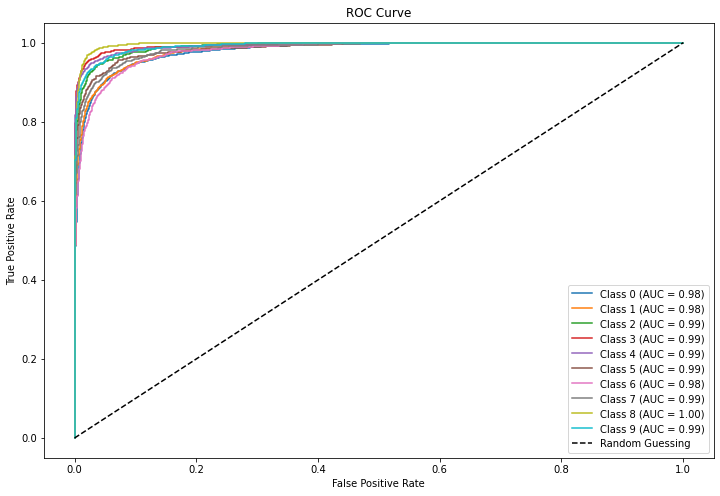

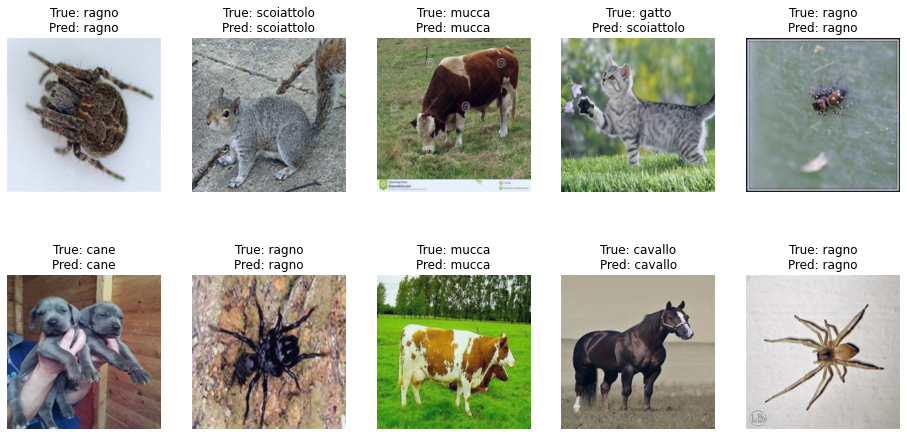

In [30]:
model = loaded_model
# Initialize lists for storing training and validation metrics
train_losses = [
    2.0358, 1.8447, 1.6973, 1.5324, 1.4040, 1.3136, 1.2383, 1.1773, 1.1106, 1.0776,
    1.0253, 0.9751, 0.9331, 0.9029, 0.8559, 0.8343, 0.8213, 0.7769, 0.7502, 0.7424,
    0.7140, 0.6948, 0.6787, 0.6411, 0.6287, 0.6186, 0.5949, 0.5817, 0.5763, 0.5673,
    0.5451, 0.5306, 0.5203, 0.5269, 0.4882, 0.4843, 0.4855, 0.4632, 0.4560, 0.4689
]

val_losses = [
    1.8617, 1.7670, 1.5121, 1.4064, 1.3755, 1.3434, 1.1597, 1.1052, 1.0605, 1.0902,
    1.0639, 1.3054, 0.9095, 0.9174, 0.7694, 0.8245, 0.7476, 0.7536, 0.9235, 0.6951,
    0.6677, 0.7002, 0.6871, 0.6723, 0.6620, 0.6094, 0.5891, 0.6284, 0.6169, 0.6026,
    0.5410, 0.5826, 0.5601, 0.5393, 0.5520, 0.5624, 0.5627, 0.5431, 0.6312, 0.5410
]

train_accuracies = [
    27.16, 35.91, 40.83, 46.51, 51.55, 54.53, 57.37, 59.74, 62.42, 63.40, 65.64, 67.31,
    68.84, 70.26, 71.42, 72.24, 73.22, 74.72, 75.23, 75.87, 76.53, 77.21, 77.82, 79.01,
    79.53, 79.70, 80.66, 81.32, 81.25, 81.62, 82.18, 83.13, 83.24, 82.95, 84.25, 84.47,
    84.52, 85.04, 85.12, 85.30
]

val_accuracies = [
    35.50, 36.57, 46.44, 50.42, 50.84, 53.44, 59.22, 61.48, 62.09, 61.94, 63.27, 59.53,
    69.40, 68.55, 74.45, 72.34, 74.33, 74.37, 70.81, 76.36, 78.69, 76.93, 77.81, 77.58,
    78.00, 80.34, 81.22, 80.91, 80.41, 80.34, 82.21, 81.37, 82.75, 84.39, 82.67, 81.83,
    82.36, 83.01, 80.83, 83.47
]



class_names = class_labels

# Test DataLoader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# Call the functions
evaluate_and_plot_metrics(model, train_losses, val_losses, train_accuracies, val_accuracies)
evaluate_on_test_data(model, test_loader)
visualize_predictions(model, test_loader)

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the optimized CNN model with overfitting prevention
class OptimizedCNNModel(nn.Module):
    def __init__(self, num_classes=10):
        super(OptimizedCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(16)  # Batch Normalization
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.25)  # Dropout layer

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(32)  # Batch Normalization
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout2 = nn.Dropout(0.25)  # Dropout layer

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(64)  # Batch Normalization
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.dropout3 = nn.Dropout(0.25)  # Dropout layer

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(128)  # Batch Normalization
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        self.dropout4 = nn.Dropout(0.25)  # Dropout layer

        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)  # Global Average Pooling
        self.fc1 = nn.Linear(128, 256)
        self.dropout_fc = nn.Dropout(0.5)  # Dropout for fully connected layer
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool1(x)
        x = self.dropout1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.maxpool2(x)
        x = self.dropout2(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.maxpool3(x)
        x = self.dropout3(x)

        x = F.relu(self.bn4(self.conv4(x)))
        x = self.maxpool4(x)
        x = self.dropout4(x)

        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)  # Dropout in the fully connected layer
        x = self.fc2(x)
        return x

# Instantiate the optimized model with overfitting prevention
optimized_model = OptimizedCNNModel(num_classes=10)

# Print the optimized model
print(optimized_model)

# Calculate total trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(optimized_model)
print(f"Total Parameters: {total_params}")


OptimizedCNNModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.25, inplace=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, trac

In [45]:
from torchmetrics.classification import MulticlassAccuracy
from torch.utils.data import DataLoader


torch.cuda.empty_cache()
# del model

model = OptimizedCNNModel(num_classes=10)
# Hyperparameters
learning_rate = 0.002
batch_size = 64
epochs = 25
num_classes = 10  # Number of classes in your dataset

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Accuracy metric
accuracy_metric = MulticlassAccuracy(num_classes=num_classes).to(device)

# DataLoaders for training and validation datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Move the model to the appropriate device
model = model.to(device)

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Training phase
    for images, labels in train_loader:
        # Move data to GPU if available
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%")

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            # Move data to GPU if available
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%")

Using device: cuda
Epoch [1/25], Loss: 1.9568, Accuracy: 30.32%
Validation Loss: 1.8173, Validation Accuracy: 35.50%
Epoch [2/25], Loss: 1.7565, Accuracy: 38.57%
Validation Loss: 1.9759, Validation Accuracy: 31.18%
Epoch [3/25], Loss: 1.6277, Accuracy: 42.75%
Validation Loss: 1.4380, Validation Accuracy: 48.28%
Epoch [4/25], Loss: 1.5458, Accuracy: 45.99%
Validation Loss: 2.1781, Validation Accuracy: 27.16%
Epoch [5/25], Loss: 1.4719, Accuracy: 49.14%
Validation Loss: 1.6266, Validation Accuracy: 41.58%
Epoch [6/25], Loss: 1.4162, Accuracy: 50.90%
Validation Loss: 1.9333, Validation Accuracy: 35.12%
Epoch [7/25], Loss: 1.3717, Accuracy: 52.16%
Validation Loss: 1.4703, Validation Accuracy: 51.68%
Epoch [8/25], Loss: 1.3396, Accuracy: 53.23%
Validation Loss: 1.4639, Validation Accuracy: 45.72%
Epoch [9/25], Loss: 1.2924, Accuracy: 54.82%
Validation Loss: 1.5667, Validation Accuracy: 46.56%
Epoch [10/25], Loss: 1.2701, Accuracy: 55.76%
Validation Loss: 1.6902, Validation Accuracy: 43.57%


In [46]:
# Additional training for 35 more epochs
# Adjust the starting epoch and total number of epochs accordingly
additional_epochs = 35
start_epoch = epochs  # Starting epoch based on the previous training
total_epochs = start_epoch + additional_epochs

for epoch in range(start_epoch, total_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Training phase
    for images, labels in train_loader:
        # Move data to GPU if available
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{total_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%")

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            # Move data to GPU if available
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%")


Epoch [26/60], Loss: 0.9991, Accuracy: 65.92%
Validation Loss: 1.6387, Validation Accuracy: 49.16%
Epoch [27/60], Loss: 0.9927, Accuracy: 66.42%
Validation Loss: 1.5637, Validation Accuracy: 51.30%
Epoch [28/60], Loss: 0.9844, Accuracy: 66.73%
Validation Loss: 1.2914, Validation Accuracy: 56.35%
Epoch [29/60], Loss: 0.9785, Accuracy: 66.89%
Validation Loss: 1.3355, Validation Accuracy: 55.47%
Epoch [30/60], Loss: 0.9626, Accuracy: 67.12%
Validation Loss: 1.1356, Validation Accuracy: 61.40%
Epoch [31/60], Loss: 0.9668, Accuracy: 67.24%
Validation Loss: 1.0122, Validation Accuracy: 64.77%
Epoch [32/60], Loss: 0.9542, Accuracy: 67.72%
Validation Loss: 0.9991, Validation Accuracy: 66.34%
Epoch [33/60], Loss: 0.9408, Accuracy: 67.92%
Validation Loss: 1.2630, Validation Accuracy: 57.46%
Epoch [34/60], Loss: 0.9416, Accuracy: 68.17%
Validation Loss: 1.2473, Validation Accuracy: 59.10%
Epoch [35/60], Loss: 0.9260, Accuracy: 68.73%
Validation Loss: 1.2188, Validation Accuracy: 59.30%
Epoch [36/

Phase 4


In [13]:
import os
import shutil
import random

# Define paths
original_dir = 'Dog Feelings'
base_dir = 'Dog_Feelings_processed'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Create directories
for dir_path in [train_dir, val_dir, test_dir]:
    os.makedirs(dir_path, exist_ok=True)

# Split data
split_ratios = {'train': 0.7, 'val': 0.1, 'test': 0.2}
classes = os.listdir(original_dir)

for class_name in classes:
    class_dir = os.path.join(original_dir, class_name)
    images = os.listdir(class_dir)
    random.shuffle(images)

    train_cutoff = int(split_ratios['train'] * len(images))
    val_cutoff = train_cutoff + int(split_ratios['val'] * len(images))

    splits = {
        'train': images[:train_cutoff],
        'val': images[train_cutoff:val_cutoff],
        'test': images[val_cutoff:]
    }

    for split, image_list in splits.items():
        split_class_dir = os.path.join(base_dir, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)
        for image in image_list:
            src = os.path.join(class_dir, image)
            dst = os.path.join(split_class_dir, image)
            shutil.copy(src, dst)

print("Data successfully split into train, val, and test sets!")


Data successfully split into train, val, and test sets!


In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from PIL import Image


# Define directories for train, val, and test
train_dir = 'Dog_Feelings_processed/train'
val_dir = 'Dog_Feelings_processed/val'
test_dir = 'Dog_Feelings_processed/test'

# Define image transformations

# Define image transformations for training
# train_transforms = transforms.Compose([
#     transforms.Lambda(lambda img: img.convert("RGBA") if img.mode == "P" else img),  # Ensure images are RGBA
#     transforms.Resize((224, 224)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(20),
#     transforms.RandomAffine(degrees=0, translate=None, scale=(0.8, 1.2), shear=None),  # Zoom via scaling
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Example for ImageNet normalization
# ])


# Define image transformations for training
train_transforms = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGBA") if img.mode == "P" else img),  # Ensure images are RGBA
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, translate=None, scale=(0.8, 1.2), shear=None),  # Zoom via scaling
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Example for ImageNet normalization
])

# Define image transformations for validation and testing
val_test_transforms = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGBA") if img.mode == "P" else img),  # Ensure images are RGBA
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Example for ImageNet normalization
])



# Load the datasets
train_dataset3 = ImageFolder(root=train_dir, transform=train_transforms)
val_dataset3 = ImageFolder(root=val_dir, transform=val_test_transforms)
test_dataset3 = ImageFolder(root=test_dir, transform=val_test_transforms)

# Create DataLoader for batching
train_loader3 = DataLoader(train_dataset3, batch_size=32, shuffle=True)
val_loader3 = DataLoader(val_dataset3, batch_size=32, shuffle=False)
test_loader3 = DataLoader(test_dataset3, batch_size=32, shuffle=False)

# Get class labels
class_labels = train_dataset3.classes  # List of class names (subfolder names)

# Print class labels
print("Class Labels:", class_labels)

# To check if everything works fine, you can print the size of batches and corresponding labels
for images, labels in train_loader:
    print("Images size:", images.size())  # Images: (batch_size, channels, height, width)
    print("Labels (batch):", labels)  # Labels: (batch_size)
    # Convert numeric labels to class names
    label_names = [class_labels[label] for label in labels]
    print("Label Names (batch):", label_names)  # Corresponding class names
    break  # Print only the first batch


Class Labels: ['dog A relaxed dog stands tall with its tail held high', 'dog Barking', 'dog Growling', 'dog Licking image', 'dog Nudging image', 'dog Perked-up ears', 'dog Soft open eyes', 'dog Whining', 'dog Yawning image', 'dog tail wags']
Images size: torch.Size([32, 3, 224, 224])
Labels (batch): tensor([7, 6, 8, 1, 8, 8, 7, 5, 6, 6, 8, 8, 4, 4, 2, 8, 3, 4, 8, 4, 5, 7, 7, 9,
        0, 7, 6, 7, 4, 0, 1, 5])
Label Names (batch): ['dog Whining', 'dog Soft open eyes', 'dog Yawning image', 'dog Barking', 'dog Yawning image', 'dog Yawning image', 'dog Whining', 'dog Perked-up ears', 'dog Soft open eyes', 'dog Soft open eyes', 'dog Yawning image', 'dog Yawning image', 'dog Nudging image', 'dog Nudging image', 'dog Growling', 'dog Yawning image', 'dog Licking image', 'dog Nudging image', 'dog Yawning image', 'dog Nudging image', 'dog Perked-up ears', 'dog Whining', 'dog Whining', 'dog tail wags', 'dog A relaxed dog stands tall with its tail held high', 'dog Whining', 'dog Soft open eyes', 

In [186]:
import pickle
import torch

# Load the pickled model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model_save_path = "fit_model_of_phase1.pkl"
with open(model_save_path, 'rb') as f:
    loaded_model = pickle.load(f)

loaded_model = loaded_model.to(device)  # Move the model to the appropriate device
# new_dropout_rate = 0.55 # Set the desired dropout rate
# loaded_model.dropout1 = nn.Dropout(new_dropout_rate)

# loaded_model.fc1 = nn.Linear(256, 32).to(device)
# loaded_model.fc2 = nn.Linear(32, 10).to(device)


print("Model loaded successfully!")
print(loaded_model)

Using device: cuda
Model loaded successfully!
CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool4): MaxPool2d(kernel_size=2, stride

In [187]:
for param in loaded_model.parameters():
    param.requires_grad = False

# Unfreeze

# for param in loaded_model.batchnorm4.parameters():
#     param.requires_grad = True

# for param in loaded_model.maxpool4.parameters():
#     param.requires_grad = True

# for param in loaded_model.conv4.parameters():
#     param.requires_grad = True

# for param in loaded_model.global_avg_pool.parameters():
#     param.requires_grad = True

for param in loaded_model.dropout1.parameters():
    param.requires_grad = True

for param in loaded_model.fc1.parameters():
    param.requires_grad = True

for param in loaded_model.fc2.parameters():
    param.requires_grad = True

# Now you can proceed with training.

In [188]:
import torch
import pickle
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Load the pre-trained model
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model_save_path = "fit_model_of_phase1.pkl"

# with open(model_save_path, 'rb') as f:
#     loaded_model = pickle.load(f)

# loaded_model = loaded_model.to(device)
# print("Model loaded successfully!")

# # Freeze all layers except the last fully connected layer
# for param in loaded_model.parameters():
#     param.requires_grad = False

# for param in loaded_model.fc2.parameters():
#     param.requires_grad = True

# print("Frozen all layers except the final layer.")

# Prepare the dataset
# transform = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
# ])

# train_dataset = datasets.ImageFolder(root="path_to_train_dataset", transform=transform)
# test_dataset = datasets.ImageFolder(root="path_to_test_dataset", transform=transform)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

train_dataset = train_dataset3
val_dataset = val_dataset3
test_dataset = test_dataset3

train_loader = train_loader3
val_loader = val_loader3
test_loader = test_loader3 

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, loaded_model.parameters()), lr=0.017)

# Train the model with added metrics
num_epochs = 40
loaded_model.train()

for epoch in range(num_epochs):
    # Initialize running metrics for training
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training loop
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = loaded_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    # Calculate training metrics
    train_loss = running_loss / len(train_loader)
    train_accuracy = (correct_train / total_train) * 100  # Convert to percentage

    # Validation loop
    loaded_model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = loaded_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    # Calculate validation metrics
    val_loss /= len(val_loader)
    val_accuracy = (correct_val / total_val) * 100  # Convert to percentage

    # Print metrics for the epoch
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"  Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

print("Training complete!")

# Save the trained model
trained_model_path = "fine_tuned_model_phase4_1.pkl"
with open(trained_model_path, 'wb') as f:
    pickle.dump(loaded_model, f)

print(f"Trained model saved at {trained_model_path}!")


Epoch 1/40
  Train Loss: 3.2022, Train Accuracy: 15.77%
  Val Loss: 2.4326, Val Accuracy: 15.00%
Epoch 2/40
  Train Loss: 2.3289, Train Accuracy: 17.98%
  Val Loss: 2.2275, Val Accuracy: 23.33%
Epoch 3/40
  Train Loss: 2.2152, Train Accuracy: 22.08%
  Val Loss: 2.1749, Val Accuracy: 26.67%
Epoch 4/40
  Train Loss: 2.1461, Train Accuracy: 22.71%
  Val Loss: 2.1178, Val Accuracy: 33.33%
Epoch 5/40
  Train Loss: 2.0727, Train Accuracy: 24.29%
  Val Loss: 2.0665, Val Accuracy: 35.00%
Epoch 6/40
  Train Loss: 2.0042, Train Accuracy: 28.39%
  Val Loss: 2.0177, Val Accuracy: 33.33%
Epoch 7/40
  Train Loss: 1.9164, Train Accuracy: 29.34%
  Val Loss: 1.9548, Val Accuracy: 36.67%
Epoch 8/40
  Train Loss: 1.8507, Train Accuracy: 31.55%
  Val Loss: 1.9101, Val Accuracy: 35.00%
Epoch 9/40
  Train Loss: 1.7913, Train Accuracy: 35.02%
  Val Loss: 1.9186, Val Accuracy: 31.67%
Epoch 10/40
  Train Loss: 1.6921, Train Accuracy: 41.32%
  Val Loss: 1.8273, Val Accuracy: 38.33%
Epoch 11/40
  Train Loss: 1.6

In [149]:
import torch
import pickle
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

train_dataset = train_dataset3
val_dataset = val_dataset3
test_dataset = test_dataset3

train_loader = train_loader3
val_loader = val_loader3
test_loader = test_loader3 

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, loaded_model.parameters()), lr=0.03)

# Train the model with added metrics
num_epochs = 50
loaded_model.train()

for epoch in range(num_epochs):
    # Initialize running metrics for training
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training loop
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = loaded_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    # Calculate training metrics
    train_loss = running_loss / len(train_loader)
    train_accuracy = (correct_train / total_train) * 100  # Convert to percentage

    # Validation loop
    loaded_model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = loaded_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    # Calculate validation metrics
    val_loss /= len(val_loader)
    val_accuracy = (correct_val / total_val) * 100  # Convert to percentage

    # Print metrics for the epoch
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"  Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

print("Training complete!")

# Save the trained model
trained_model_path = "fine_tuned_model_phase3.pkl"
with open(trained_model_path, 'wb') as f:
    pickle.dump(loaded_model, f)

print(f"Trained model saved at {trained_model_path}!")


Epoch 1/50
  Train Loss: 3.0056, Train Accuracy: 13.25%
  Val Loss: 2.3577, Val Accuracy: 11.67%
Epoch 2/50
  Train Loss: 2.2754, Train Accuracy: 15.77%
  Val Loss: 2.2774, Val Accuracy: 15.00%
Epoch 3/50
  Train Loss: 2.1827, Train Accuracy: 21.45%
  Val Loss: 2.2152, Val Accuracy: 25.00%
Epoch 4/50
  Train Loss: 2.0904, Train Accuracy: 25.24%
  Val Loss: 2.0962, Val Accuracy: 26.67%
Epoch 5/50
  Train Loss: 1.9826, Train Accuracy: 31.23%
  Val Loss: 2.0544, Val Accuracy: 31.67%
Epoch 6/50
  Train Loss: 1.8791, Train Accuracy: 32.81%
  Val Loss: 1.9704, Val Accuracy: 35.00%
Epoch 7/50
  Train Loss: 1.8213, Train Accuracy: 35.65%
  Val Loss: 1.8753, Val Accuracy: 35.00%
Epoch 8/50
  Train Loss: 1.7289, Train Accuracy: 38.49%
  Val Loss: 1.8319, Val Accuracy: 41.67%
Epoch 9/50
  Train Loss: 1.6321, Train Accuracy: 45.11%
  Val Loss: 1.7553, Val Accuracy: 43.33%
Epoch 10/50
  Train Loss: 1.5717, Train Accuracy: 44.48%
  Val Loss: 1.7538, Val Accuracy: 40.00%
Epoch 11/50
  Train Loss: 1.4

Using device: cuda
Model loaded successfully!


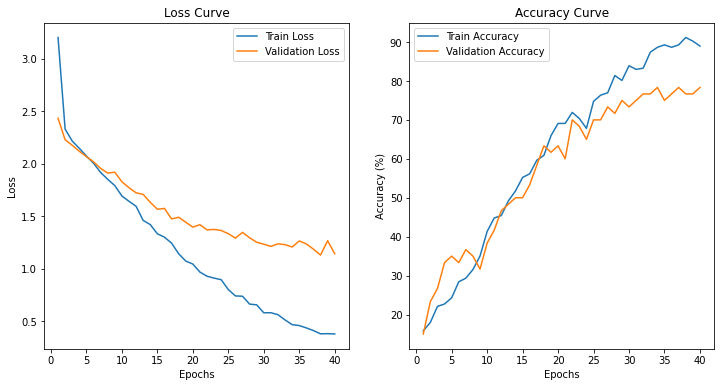

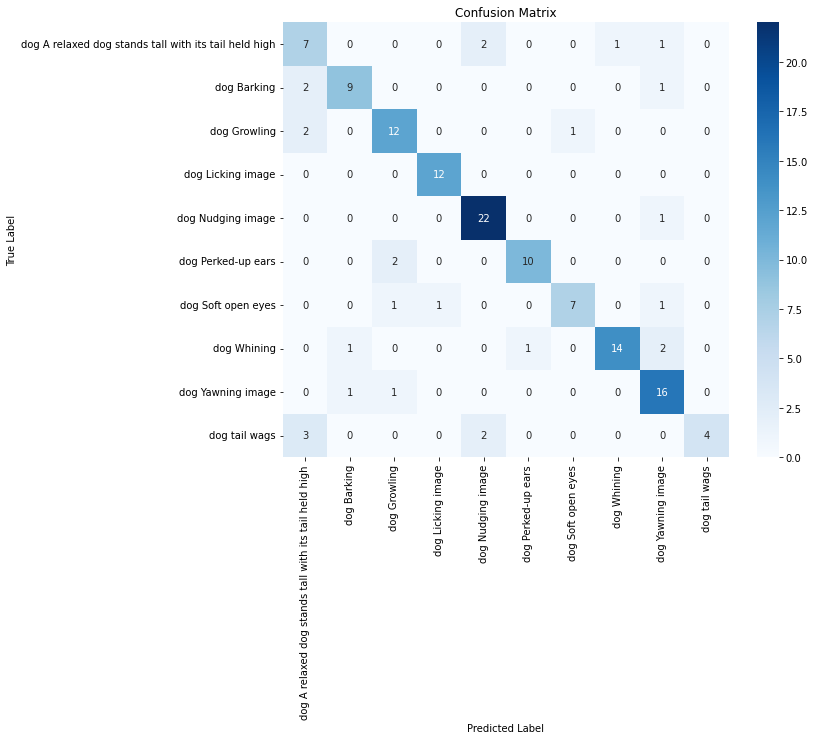

Precision: 0.8261, Recall: 0.8071, F1 Score: 0.8054
Test Accuracy: 80.71%


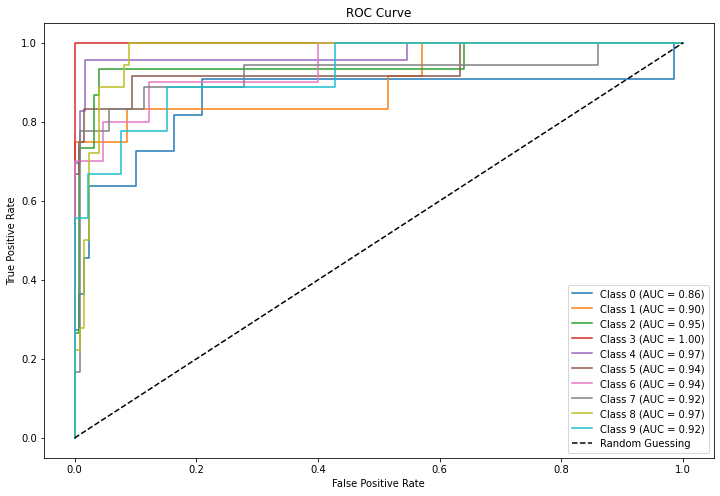

C:\Users\ASUS\AppData\Roaming\Python\Python310\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


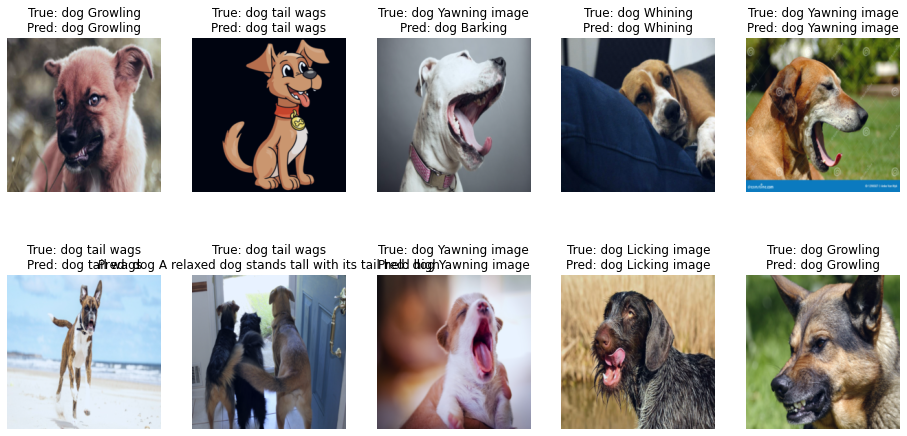

In [189]:
# Load the pickled model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model_save_path = "fine_tuned_model_phase4.pkl"
with open(model_save_path, 'rb') as f:
    loaded_model = pickle.load(f)

loaded_model = loaded_model.to(device)  # Move the model to the appropriate device
print("Model loaded successfully!")
model = loaded_model
# Initialize lists for storing training and validation metrics
train_losses = [
    3.2022, 2.3289, 2.2152, 2.1461, 2.0727, 2.0042, 1.9164, 1.8507, 1.7913, 1.6921,
    1.6412, 1.5939, 1.4591, 1.4194, 1.3321, 1.2996, 1.2429, 1.1420, 1.0722, 1.0435,
    0.9669, 0.9276, 0.9095, 0.8942, 0.8004, 0.7398, 0.7369, 0.6619, 0.6548, 0.5792,
    0.5798, 0.5610, 0.5110, 0.4662, 0.4574, 0.4351, 0.4094, 0.3787, 0.3804, 0.3773
]

val_losses = [
    2.4326, 2.2275, 2.1749, 2.1178, 2.0665, 2.0177, 1.9548, 1.9101, 1.9186, 1.8273,
    1.7708, 1.7223, 1.7071, 1.6318, 1.5656, 1.5732, 1.4738, 1.4893, 1.4421, 1.3956,
    1.4182, 1.3693, 1.3732, 1.3630, 1.3325, 1.2910, 1.3453, 1.2941, 1.2508, 1.2327,
    1.2115, 1.2364, 1.2283, 1.2060, 1.2633, 1.2354, 1.1853, 1.1291, 1.2659, 1.1418
]

train_accuracies = [
    15.77, 17.98, 22.08, 22.71, 24.29, 28.39, 29.34, 31.55, 35.02, 41.32,
    44.79, 45.43, 49.21, 51.74, 55.21, 56.15, 59.62, 60.88, 65.93, 69.09,
    69.09, 71.92, 70.35, 67.82, 74.76, 76.34, 76.97, 81.39, 80.13, 83.91,
    82.97, 83.28, 87.38, 88.64, 89.27, 88.64, 89.27, 91.17, 90.22, 88.96
]

val_accuracies = [
    15.00, 23.33, 26.67, 33.33, 35.00, 33.33, 36.67, 35.00, 31.67, 38.33,
    41.67, 46.67, 48.33, 50.00, 50.00, 53.33, 58.33, 63.33, 61.67, 63.33,
    60.00, 70.00, 68.33, 65.00, 70.00, 70.00, 73.33, 71.67, 75.00, 73.33,
    75.00, 76.67, 76.67, 78.33, 75.00, 76.67, 78.33, 76.67, 76.67, 78.33
]






class_names = class_labels

# Test DataLoader
test_loader = DataLoader(test_dataset3, batch_size=32, shuffle=False)
# Call the functions
evaluate_and_plot_metrics(model, train_losses, val_losses, train_accuracies, val_accuracies)
evaluate_on_test_data(model, test_loader)
visualize_predictions(model, test_loader)

In [195]:
import pickle
import torch

# Load the pickled model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model_save_path = "fit_model_of_phase1.pkl"
with open(model_save_path, 'rb') as f:
    loaded_model = pickle.load(f)

loaded_model = loaded_model.to(device)  # Move the model to the appropriate device
# new_dropout_rate = 0.55 # Set the desired dropout rate
# loaded_model.dropout1 = nn.Dropout(new_dropout_rate)

# loaded_model.fc1 = nn.Linear(256, 32).to(device)
# loaded_model.fc2 = nn.Linear(32, 10).to(device)


print("Model loaded successfully!")
# print(loaded_model)

Using device: cuda
Model loaded successfully!


In [196]:
for param in loaded_model.parameters():
    param.requires_grad = False

# Unfreeze

for param in loaded_model.batchnorm4.parameters():
    param.requires_grad = True

for param in loaded_model.maxpool4.parameters():
    param.requires_grad = True

for param in loaded_model.conv4.parameters():
    param.requires_grad = True

for param in loaded_model.global_avg_pool.parameters():
    param.requires_grad = True

for param in loaded_model.dropout1.parameters():
    param.requires_grad = True

for param in loaded_model.fc1.parameters():
    param.requires_grad = True

for param in loaded_model.fc2.parameters():
    param.requires_grad = True

# Now you can proceed with training.

In [197]:
import torch
import pickle
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Load the pre-trained model
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model_save_path = "fit_model_of_phase1.pkl"

# with open(model_save_path, 'rb') as f:
#     loaded_model = pickle.load(f)

# loaded_model = loaded_model.to(device)
# print("Model loaded successfully!")

# # Freeze all layers except the last fully connected layer
# for param in loaded_model.parameters():
#     param.requires_grad = False

# for param in loaded_model.fc2.parameters():
#     param.requires_grad = True

# print("Frozen all layers except the final layer.")

# Prepare the dataset
# transform = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
# ])

# train_dataset = datasets.ImageFolder(root="path_to_train_dataset", transform=transform)
# test_dataset = datasets.ImageFolder(root="path_to_test_dataset", transform=transform)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

train_dataset = train_dataset3
val_dataset = val_dataset3
test_dataset = test_dataset3

train_loader = train_loader3
val_loader = val_loader3
test_loader = test_loader3 

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, loaded_model.parameters()), lr=0.012)

# Train the model with added metrics
num_epochs = 30
loaded_model.train()

for epoch in range(num_epochs):
    # Initialize running metrics for training
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training loop
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = loaded_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    # Calculate training metrics
    train_loss = running_loss / len(train_loader)
    train_accuracy = (correct_train / total_train) * 100  # Convert to percentage

    # Validation loop
    loaded_model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = loaded_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    # Calculate validation metrics
    val_loss /= len(val_loader)
    val_accuracy = (correct_val / total_val) * 100  # Convert to percentage

    # Print metrics for the epoch
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"  Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

print("Training complete!")

# Save the trained model
trained_model_path = "fine_tuned_model_phase4_2.pkl"
with open(trained_model_path, 'wb') as f:
    pickle.dump(loaded_model, f)

print(f"Trained model saved at {trained_model_path}!")


Epoch 1/30
  Train Loss: 3.0129, Train Accuracy: 14.20%
  Val Loss: 2.5030, Val Accuracy: 15.00%
Epoch 2/30
  Train Loss: 2.3477, Train Accuracy: 17.03%
  Val Loss: 2.2524, Val Accuracy: 16.67%
Epoch 3/30
  Train Loss: 2.1886, Train Accuracy: 22.08%
  Val Loss: 2.1104, Val Accuracy: 21.67%
Epoch 4/30
  Train Loss: 2.0165, Train Accuracy: 27.44%
  Val Loss: 2.0666, Val Accuracy: 30.00%
Epoch 5/30
  Train Loss: 1.9778, Train Accuracy: 27.76%
  Val Loss: 2.0585, Val Accuracy: 28.33%
Epoch 6/30
  Train Loss: 1.8779, Train Accuracy: 32.18%
  Val Loss: 1.9947, Val Accuracy: 28.33%
Epoch 7/30
  Train Loss: 1.8089, Train Accuracy: 35.96%
  Val Loss: 2.1792, Val Accuracy: 26.67%
Epoch 8/30
  Train Loss: 1.7177, Train Accuracy: 41.64%
  Val Loss: 1.9869, Val Accuracy: 33.33%
Epoch 9/30
  Train Loss: 1.6007, Train Accuracy: 45.11%
  Val Loss: 1.7047, Val Accuracy: 36.67%
Epoch 10/30
  Train Loss: 1.5020, Train Accuracy: 49.21%
  Val Loss: 1.8023, Val Accuracy: 40.00%
Epoch 11/30
  Train Loss: 1.4

Using device: cuda
Model loaded successfully!


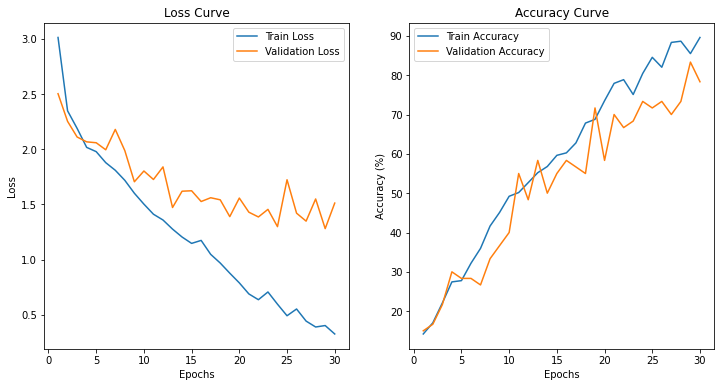

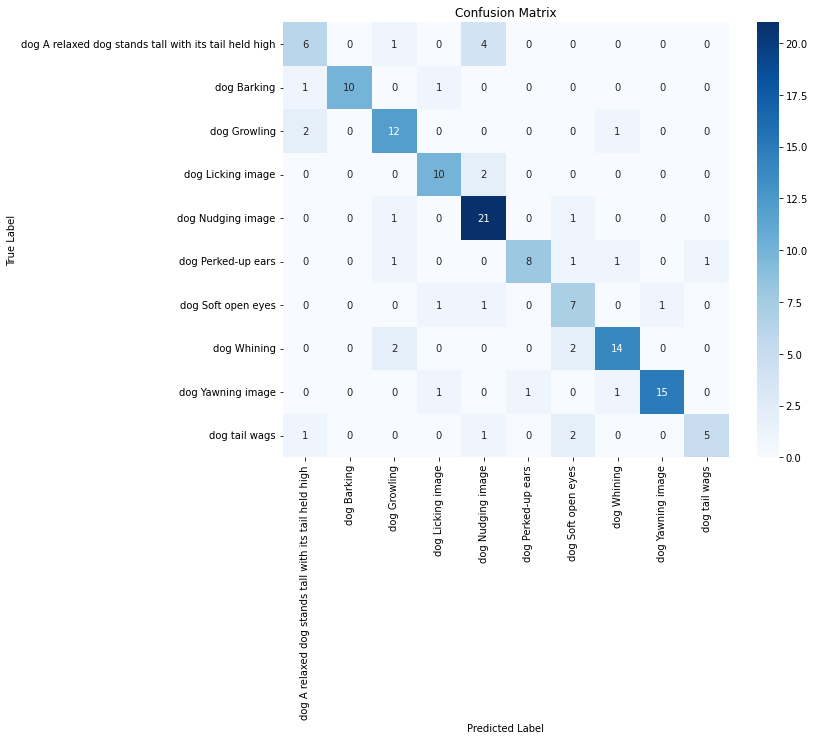

Precision: 0.7880, Recall: 0.7714, F1 Score: 0.7724
Test Accuracy: 77.14%


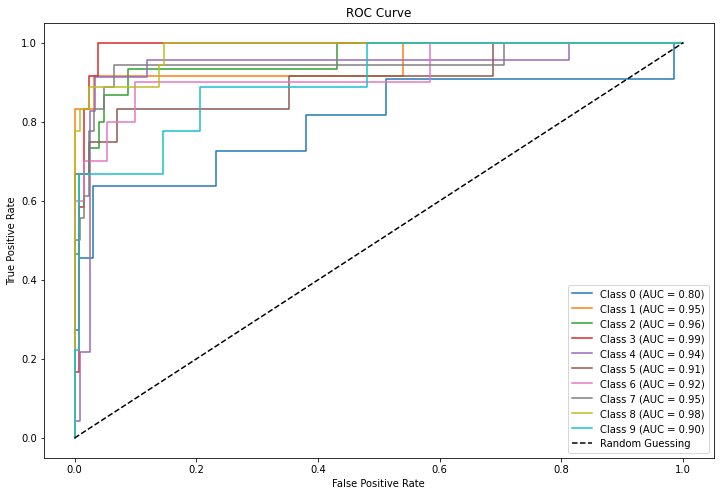

C:\Users\ASUS\AppData\Roaming\Python\Python310\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


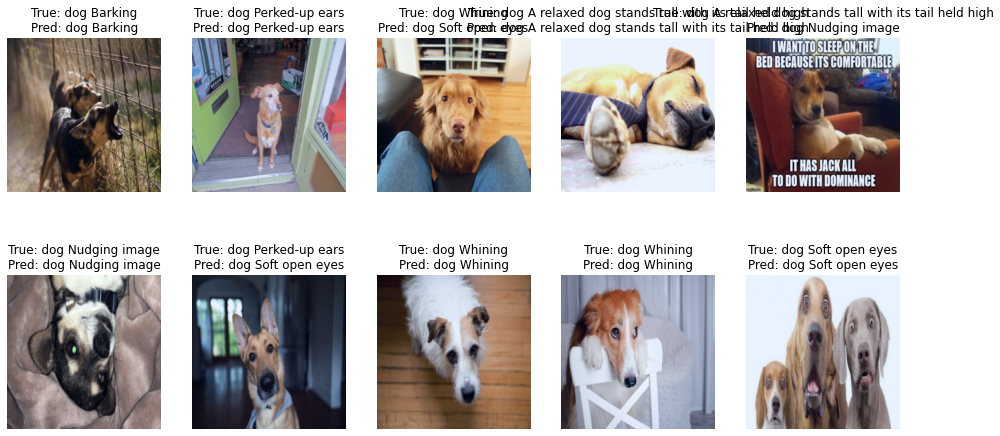

In [198]:
# Load the pickled model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model_save_path = "fine_tuned_model_phase4_2.pkl"
with open(model_save_path, 'rb') as f:
    loaded_model = pickle.load(f)

loaded_model = loaded_model.to(device)  # Move the model to the appropriate device
print("Model loaded successfully!")
model = loaded_model
# Initialize lists for storing training and validation metrics
train_losses = [
    3.0129, 2.3477, 2.1886, 2.0165, 1.9778, 1.8779, 1.8089, 1.7177, 1.6007, 1.5020,
    1.4105, 1.3581, 1.2757, 1.2038, 1.1461, 1.1731, 1.0467, 0.9680, 0.8761, 0.7882,
    0.6880, 0.6356, 0.7057, 0.5950, 0.4901, 0.5513, 0.4416, 0.3882, 0.4013, 0.3249
]

val_losses = [
    2.5030, 2.2524, 2.1104, 2.0666, 2.0585, 1.9947, 2.1792, 1.9869, 1.7047, 1.8023,
    1.7254, 1.8394, 1.4714, 1.6191, 1.6232, 1.5257, 1.5600, 1.5411, 1.3886, 1.5571,
    1.4289, 1.3857, 1.4545, 1.2979, 1.7230, 1.4199, 1.3479, 1.5488, 1.2800, 1.5114
]

train_accuracies = [
    14.20, 17.03, 22.08, 27.44, 27.76, 32.18, 35.96, 41.64, 45.11, 49.21,
    50.16, 52.68, 55.21, 56.78, 59.62, 60.25, 62.78, 67.82, 68.77, 73.50,
    77.92, 78.86, 75.08, 80.44, 84.54, 82.02, 88.33, 88.64, 85.49, 89.59
]

val_accuracies = [
    15.00, 16.67, 21.67, 30.00, 28.33, 28.33, 26.67, 33.33, 36.67, 40.00,
    55.00, 48.33, 58.33, 50.00, 55.00, 58.33, 56.67, 55.00, 71.67, 58.33,
    70.00, 66.67, 68.33, 73.33, 71.67, 73.33, 70.00, 73.33, 83.33, 78.33
]






class_names = class_labels

# Test DataLoader
test_loader = DataLoader(test_dataset3, batch_size=32, shuffle=False)
# Call the functions
evaluate_and_plot_metrics(model, train_losses, val_losses, train_accuracies, val_accuracies)
evaluate_on_test_data(model, test_loader)
visualize_predictions(model, test_loader)

Phase 4.2

In [202]:
import os
import shutil
import random

# Define paths
original_dir = 'DCH'
base_dir = 'DCH_processed'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Create directories
for dir_path in [train_dir, val_dir, test_dir]:
    os.makedirs(dir_path, exist_ok=True)

# Split data
split_ratios = {'train': 0.7, 'val': 0.1, 'test': 0.2}
classes = os.listdir(original_dir)

for class_name in classes:
    class_dir = os.path.join(original_dir, class_name)
    images = os.listdir(class_dir)
    random.shuffle(images)

    train_cutoff = int(split_ratios['train'] * len(images))
    val_cutoff = train_cutoff + int(split_ratios['val'] * len(images))

    splits = {
        'train': images[:train_cutoff],
        'val': images[train_cutoff:val_cutoff],
        'test': images[val_cutoff:]
    }

    for split, image_list in splits.items():
        split_class_dir = os.path.join(base_dir, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)
        for image in image_list:
            src = os.path.join(class_dir, image)
            dst = os.path.join(split_class_dir, image)
            shutil.copy(src, dst)

print("Data successfully split into train, val, and test sets!")


Data successfully split into train, val, and test sets!


In [3]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from PIL import Image


# Define directories for train, val, and test
train_dir = 'DCH_processed/train'
val_dir = 'DCH_processed/val'
test_dir = 'DCH_processed/test'

# Define image transformations

# Define image transformations for training
# train_transforms = transforms.Compose([
#     transforms.Lambda(lambda img: img.convert("RGBA") if img.mode == "P" else img),  # Ensure images are RGBA
#     transforms.Resize((224, 224)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(20),
#     transforms.RandomAffine(degrees=0, translate=None, scale=(0.8, 1.2), shear=None),  # Zoom via scaling
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Example for ImageNet normalization
# ])


# Define image transformations for training
train_transforms = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGBA") if img.mode == "P" else img),  # Ensure images are RGBA
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, translate=None, scale=(0.8, 1.2), shear=None),  # Zoom via scaling
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Example for ImageNet normalization
])

# Define image transformations for validation and testing
val_test_transforms = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGBA") if img.mode == "P" else img),  # Ensure images are RGBA
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Example for ImageNet normalization
])



# Load the datasets
train_dataset4 = ImageFolder(root=train_dir, transform=train_transforms)
val_dataset4 = ImageFolder(root=val_dir, transform=val_test_transforms)
test_dataset4 = ImageFolder(root=test_dir, transform=val_test_transforms)

# Create DataLoader for batching
train_loader4 = DataLoader(train_dataset4, batch_size=32, shuffle=True)
val_loader4 = DataLoader(val_dataset4, batch_size=32, shuffle=False)
test_loader4 = DataLoader(test_dataset4, batch_size=32, shuffle=False)

# Get class labels
class_labels = train_dataset4.classes  # List of class names (subfolder names)

# Print class labels
print("Class Labels:", class_labels)

for images, labels in train_loader4:
    print("Images size:", images.size())  # Images: (batch_size, channels, height, width)
    print("Labels (batch):", labels)  # Labels: (batch_size)
    # Convert numeric labels to class names
    label_names = [class_labels[label.item()] for label in labels]
    print("Label Names (batch):", label_names)  # Corresponding class names
    break  # Print only the first batch



Class Labels: ['cats', 'dogs', 'horses']
Images size: torch.Size([32, 3, 224, 224])
Labels (batch): tensor([0, 0, 1, 2, 1, 0, 2, 0, 2, 0, 1, 1, 2, 0, 0, 0, 1, 2, 1, 0, 1, 1, 1, 0,
        2, 2, 2, 2, 0, 0, 2, 2])
Label Names (batch): ['cats', 'cats', 'dogs', 'horses', 'dogs', 'cats', 'horses', 'cats', 'horses', 'cats', 'dogs', 'dogs', 'horses', 'cats', 'cats', 'cats', 'dogs', 'horses', 'dogs', 'cats', 'dogs', 'dogs', 'dogs', 'cats', 'horses', 'horses', 'horses', 'horses', 'cats', 'cats', 'horses', 'horses']


In [216]:
import pickle
import torch

# Load the pickled model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model_save_path = "fit_model_of_phase1.pkl"
with open(model_save_path, 'rb') as f:
    loaded_model = pickle.load(f)

loaded_model = loaded_model.to(device)  # Move the model to the appropriate device
# new_dropout_rate = 0.55 # Set the desired dropout rate
# loaded_model.dropout1 = nn.Dropout(new_dropout_rate)

# loaded_model.fc1 = nn.Linear(256, 32).to(device)
loaded_model.fc2 = nn.Linear(512, 3).to(device)


print("Model loaded successfully!")
print(loaded_model)

Using device: cuda
Model loaded successfully!
CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool4): MaxPool2d(kernel_size=2, stride

In [217]:
for param in loaded_model.parameters():
    param.requires_grad = False

# Unfreeze
for param in loaded_model.dropout1.parameters():
    param.requires_grad = True

for param in loaded_model.fc1.parameters():
    param.requires_grad = True

for param in loaded_model.fc2.parameters():
    param.requires_grad = True

# Now you can proceed with training.

In [218]:
import torch
import pickle
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Load the pre-trained model
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model_save_path = "fit_model_of_phase1.pkl"

# with open(model_save_path, 'rb') as f:
#     loaded_model = pickle.load(f)

# loaded_model = loaded_model.to(device)
# print("Model loaded successfully!")

# # Freeze all layers except the last fully connected layer
# for param in loaded_model.parameters():
#     param.requires_grad = False

# for param in loaded_model.fc2.parameters():
#     param.requires_grad = True

# print("Frozen all layers except the final layer.")

# Prepare the dataset
# transform = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
# ])

# train_dataset = datasets.ImageFolder(root="path_to_train_dataset", transform=transform)
# test_dataset = datasets.ImageFolder(root="path_to_test_dataset", transform=transform)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

train_dataset = train_dataset4
val_dataset = val_dataset4
test_dataset = test_dataset4

train_loader = train_loader4
val_loader = val_loader4
test_loader = test_loader4 

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, loaded_model.parameters()), lr=0.005)

# Train the model with added metrics
num_epochs = 30
loaded_model.train()

for epoch in range(num_epochs):
    # Initialize running metrics for training
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training loop
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = loaded_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    # Calculate training metrics
    train_loss = running_loss / len(train_loader)
    train_accuracy = (correct_train / total_train) * 100  # Convert to percentage

    # Validation loop
    loaded_model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = loaded_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    # Calculate validation metrics
    val_loss /= len(val_loader)
    val_accuracy = (correct_val / total_val) * 100  # Convert to percentage

    # Print metrics for the epoch
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"  Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

print("Training complete!")

# Save the trained model
trained_model_path = "fine_tuned_model_phase4_2.pkl"
with open(trained_model_path, 'wb') as f:
    pickle.dump(loaded_model, f)

print(f"Trained model saved at {trained_model_path}!")

Epoch 1/30
  Train Loss: 0.8946, Train Accuracy: 69.16%
  Val Loss: 0.5729, Val Accuracy: 83.33%
Epoch 2/30
  Train Loss: 0.5639, Train Accuracy: 84.67%
  Val Loss: 0.3383, Val Accuracy: 92.98%
Epoch 3/30
  Train Loss: 0.3961, Train Accuracy: 86.31%
  Val Loss: 0.2579, Val Accuracy: 92.11%
Epoch 4/30
  Train Loss: 0.3863, Train Accuracy: 86.86%
  Val Loss: 0.2190, Val Accuracy: 92.98%
Epoch 5/30
  Train Loss: 0.3133, Train Accuracy: 88.69%
  Val Loss: 0.2174, Val Accuracy: 87.72%
Epoch 6/30
  Train Loss: 0.2991, Train Accuracy: 89.05%
  Val Loss: 0.1802, Val Accuracy: 94.74%
Epoch 7/30
  Train Loss: 0.2596, Train Accuracy: 90.51%
  Val Loss: 0.1628, Val Accuracy: 92.98%
Epoch 8/30
  Train Loss: 0.2404, Train Accuracy: 91.79%
  Val Loss: 0.1571, Val Accuracy: 93.86%
Epoch 9/30
  Train Loss: 0.2154, Train Accuracy: 92.70%
  Val Loss: 0.1411, Val Accuracy: 96.49%
Epoch 10/30
  Train Loss: 0.1928, Train Accuracy: 93.25%
  Val Loss: 0.1298, Val Accuracy: 97.37%
Epoch 11/30
  Train Loss: 0.2

In [ ]:
# Load the pickled model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model_save_path = "fine_tuned_model_phase4_2.pkl"
with open(model_save_path, 'rb') as f:
    loaded_model = pickle.load(f)

loaded_model = loaded_model.to(device)  # Move the model to the appropriate device
print("Model loaded successfully!")
model = loaded_model
# Initialize lists for storing training and validation metrics
train_losses = [
    0.8946, 0.5639, 0.3961, 0.3863, 0.3133, 0.2991, 0.2596, 0.2404, 0.2154, 0.1928,
    0.2022, 0.2320, 0.1811, 0.1801, 0.1923, 0.1692, 0.1886, 0.1518, 0.1466, 0.1290,
    0.1314, 0.1533, 0.1327, 0.1198, 0.1093, 0.1318, 0.1295, 0.1260, 0.0927, 0.1057
]

val_losses = [
    0.5729, 0.3383, 0.2579, 0.2190, 0.2174, 0.1802, 0.1628, 0.1571, 0.1411, 0.1298,
    0.1181, 0.1161, 0.1022, 0.1098, 0.0882, 0.0923, 0.0823, 0.0787, 0.0764, 0.0718,
    0.0831, 0.0658, 0.0638, 0.0650, 0.0608, 0.0571, 0.0604, 0.0499, 0.0446, 0.0555
]

train_accuracies = [
    69.16, 84.67, 86.31, 86.86, 88.69, 89.05, 90.51, 91.79, 92.70, 93.25,
    93.25, 93.61, 93.61, 92.88, 92.52, 93.98, 92.70, 93.61, 94.34, 96.35,
    96.17, 94.16, 95.26, 95.62, 95.80, 94.71, 95.62, 95.26, 97.26, 97.26
]

val_accuracies = [
    83.33, 92.98, 92.11, 92.98, 87.72, 94.74, 92.98, 93.86, 96.49, 97.37,
    96.49, 95.61, 98.25, 95.61, 97.37, 97.37, 97.37, 98.25, 98.25, 98.25,
    96.49, 98.25, 98.25, 97.37, 98.25, 99.12, 97.37, 99.12, 100.00, 99.12
]






class_names = class_labels

# Test DataLoader
test_loader = DataLoader(test_dataset3, batch_size=32, shuffle=False)
# Call the functions
evaluate_and_plot_metrics(model, train_losses, val_losses, train_accuracies, val_accuracies)
evaluate_on_test_data(model, test_loader)
visualize_predictions(model, test_loader)

Pretrained Model

In [221]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
import pickle

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained models
models_to_train = {
    "ResNet50": models.resnet50(pretrained=True),
    "MobileNetV2": models.mobilenet_v2(pretrained=True),
    "EfficientNetB0": models.efficientnet_b0(pretrained=True),
}

# Define a function to modify the last layer of each model
def modify_model(model, num_classes):
    if isinstance(model, models.ResNet):
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif isinstance(model, models.MobileNetV2):
        model.classifier[1] = nn.Linear(model.last_channel, num_classes)
    elif isinstance(model, models.EfficientNet):
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model

# Modify the models
num_classes = len(class_labels)
for model_name in models_to_train:
    models_to_train[model_name] = modify_model(models_to_train[model_name], num_classes)
    models_to_train[model_name].to(device)

# Training parameters
num_epochs = 10
batch_size = 32
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()

# Train and validate each model
results = {}

for model_name, model in models_to_train.items():
    print(f"\nTraining {model_name}...")
    
    # Choose layers to fine-tune
    for param in model.parameters():
        param.requires_grad = False
    for param in list(model.parameters())[-10:]:
        param.requires_grad = True

    # Define optimizer
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

    # Track best accuracy
    best_val_accuracy = 0.0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss, train_correct = 0.0, 0
        for images, labels in train_loader4:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track metrics
            train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()

        train_loss /= len(train_loader4.dataset)
        train_accuracy = 100.0 * train_correct / len(train_loader4.dataset)

        # Validation phase
        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for images, labels in val_loader4:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()

        val_loss /= len(val_loader4.dataset)
        val_accuracy = 100.0 * val_correct / len(val_loader4.dataset)

        # Save the best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            with open(f"{model_name}_best.pkl", "wb") as f:
                pickle.dump(model, f)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}% - Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    results[model_name] = best_val_accuracy

# Print final results
print("\nFinal Results:")
for model_name, accuracy in results.items():
    print(f"{model_name}: Best Validation Accuracy = {accuracy:.2f}%")


Training ResNet50...
Epoch [1/10] - Train Loss: 0.2399, Train Acc: 88.69% - Val Loss: 0.1160, Val Acc: 96.49%
Epoch [2/10] - Train Loss: 0.1397, Train Acc: 95.26% - Val Loss: 0.0209, Val Acc: 99.12%
Epoch [3/10] - Train Loss: 0.1089, Train Acc: 96.35% - Val Loss: 0.0489, Val Acc: 98.25%
Epoch [4/10] - Train Loss: 0.0664, Train Acc: 97.81% - Val Loss: 0.0081, Val Acc: 100.00%
Epoch [5/10] - Train Loss: 0.0889, Train Acc: 97.81% - Val Loss: 0.0083, Val Acc: 100.00%
Epoch [6/10] - Train Loss: 0.0621, Train Acc: 97.99% - Val Loss: 0.0200, Val Acc: 99.12%
Epoch [7/10] - Train Loss: 0.0295, Train Acc: 98.91% - Val Loss: 0.0093, Val Acc: 100.00%
Epoch [8/10] - Train Loss: 0.0339, Train Acc: 98.54% - Val Loss: 0.0034, Val Acc: 100.00%
Epoch [9/10] - Train Loss: 0.0551, Train Acc: 97.99% - Val Loss: 0.0311, Val Acc: 98.25%
Epoch [10/10] - Train Loss: 0.0475, Train Acc: 98.18% - Val Loss: 0.0079, Val Acc: 100.00%

Training MobileNetV2...
Epoch [1/10] - Train Loss: 0.2810, Train Acc: 87.96% - Va


Evaluating ResNet50...


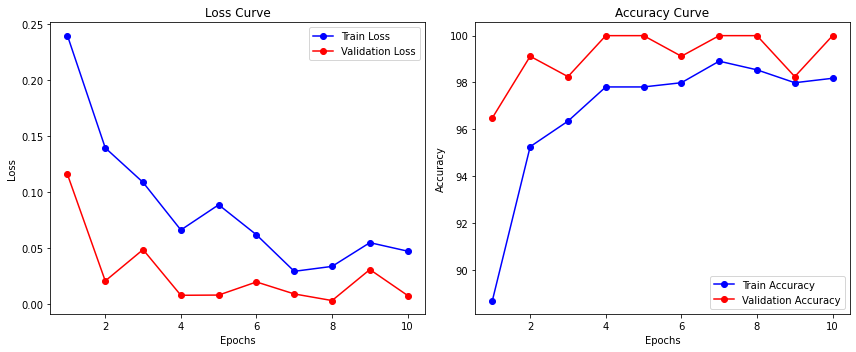


Classification Report:
              precision    recall  f1-score   support

      Class1       1.00      0.94      0.97        77
      Class2       0.91      1.00      0.95        68
      Class3       1.00      0.97      0.99        70

    accuracy                           0.97       215
   macro avg       0.97      0.97      0.97       215
weighted avg       0.97      0.97      0.97       215



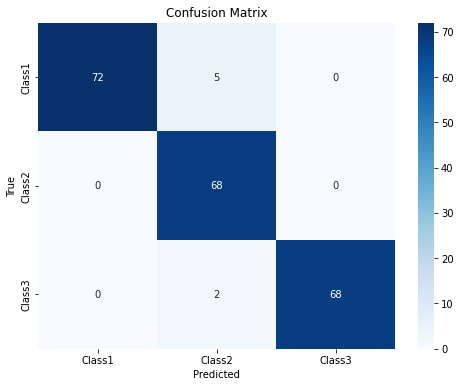

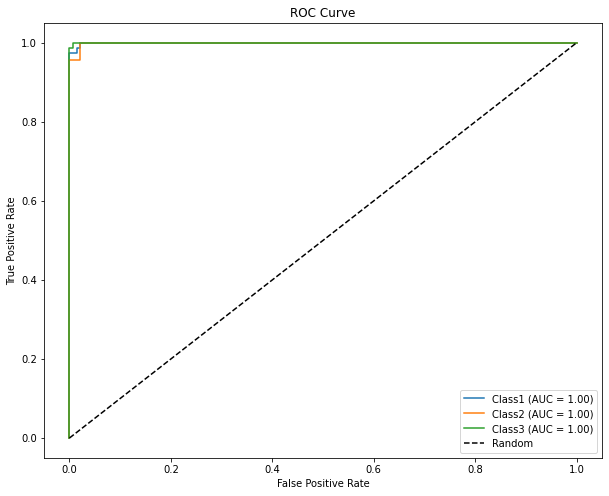

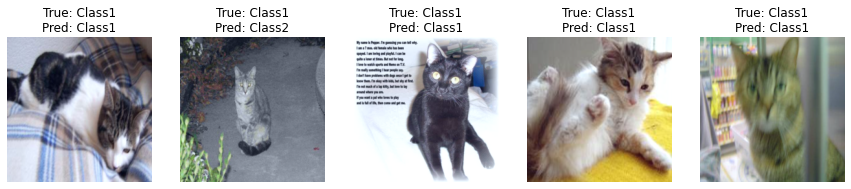


Evaluating MobileNetV2...


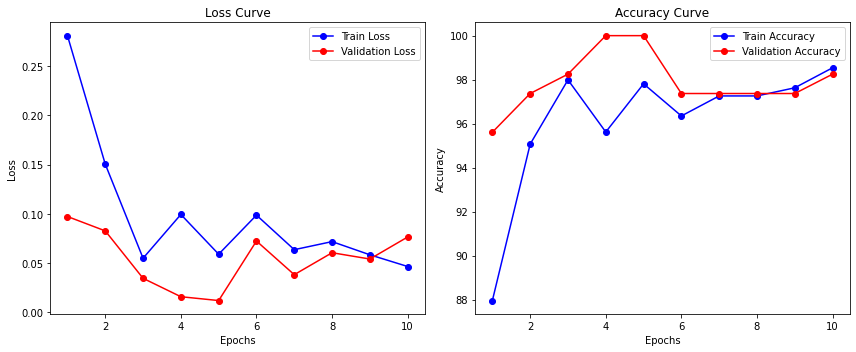


Classification Report:
              precision    recall  f1-score   support

      Class1       1.00      0.99      0.99        77
      Class2       0.99      0.99      0.99        68
      Class3       0.97      0.99      0.98        70

    accuracy                           0.99       215
   macro avg       0.99      0.99      0.99       215
weighted avg       0.99      0.99      0.99       215



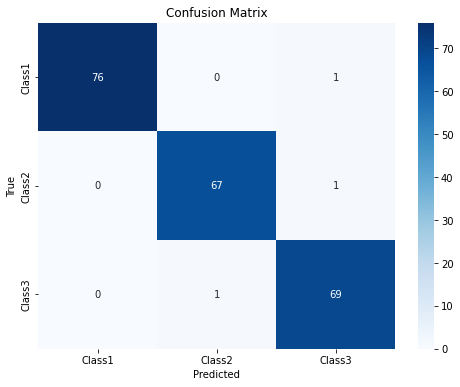

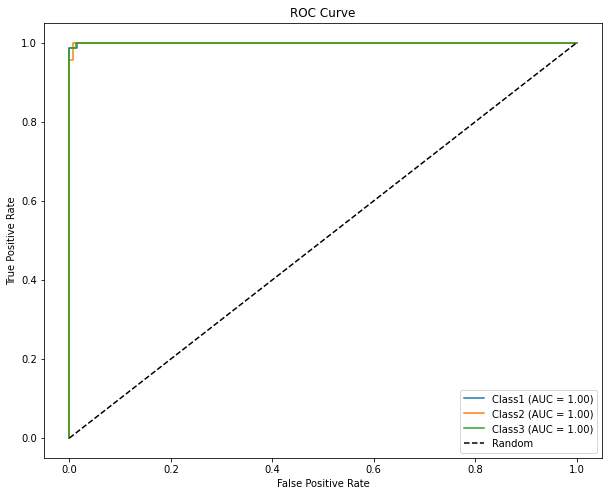

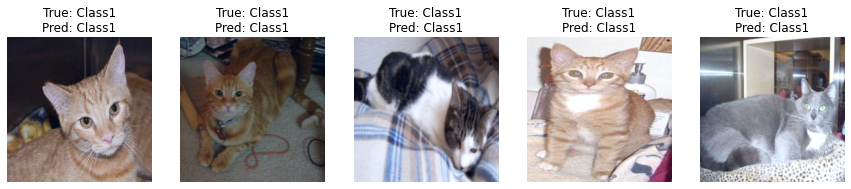


Evaluating EfficientNetB0...


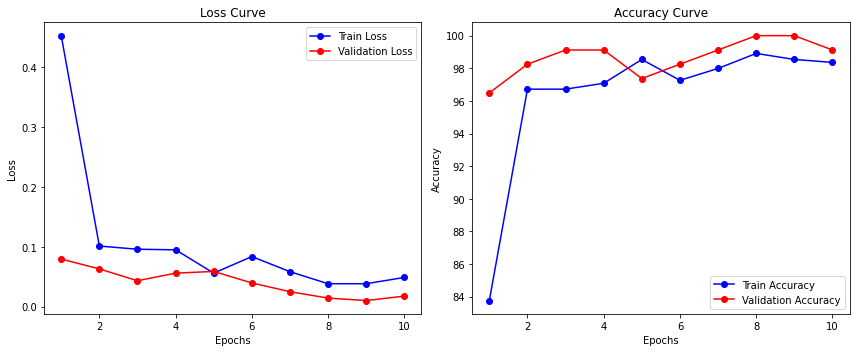


Classification Report:
              precision    recall  f1-score   support

      Class1       1.00      0.97      0.99        77
      Class2       0.96      1.00      0.98        68
      Class3       1.00      0.99      0.99        70

    accuracy                           0.99       215
   macro avg       0.99      0.99      0.99       215
weighted avg       0.99      0.99      0.99       215



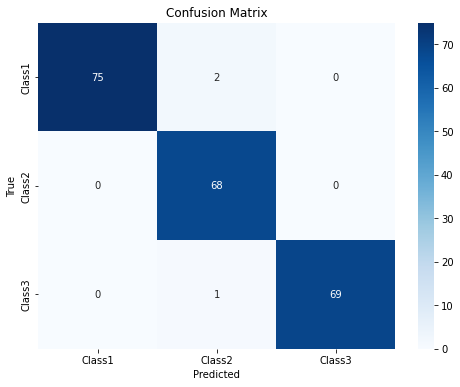

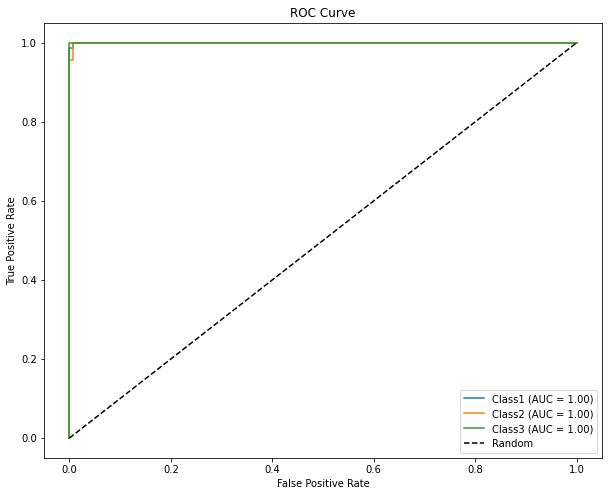

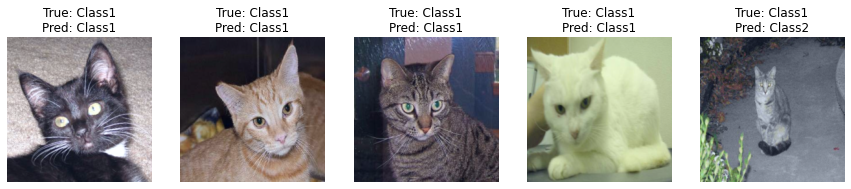

In [231]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import pickle
import torch

# Initialize empty lists
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Define data for each model
train_lossesResNet50 = [0.2399, 0.1397, 0.1089, 0.0664, 0.0889, 0.0621, 0.0295, 0.0339, 0.0551, 0.0475]
val_lossesResNet50 = [0.1160, 0.0209, 0.0489, 0.0081, 0.0083, 0.0200, 0.0093, 0.0034, 0.0311, 0.0079]
train_accuraciesResNet50 = [88.69, 95.26, 96.35, 97.81, 97.81, 97.99, 98.91, 98.54, 97.99, 98.18]
val_accuraciesResNet50 = [96.49, 99.12, 98.25, 100.00, 100.00, 99.12, 100.00, 100.00, 98.25, 100.00]

train_lossesMobileNetV2 = [0.2810, 0.1504, 0.0548, 0.0993, 0.0589, 0.0986, 0.0635, 0.0717, 0.0583, 0.0464]
val_lossesMobileNetV2 = [0.0972, 0.0826, 0.0344, 0.0157, 0.0118, 0.0723, 0.0381, 0.0604, 0.0540, 0.0764]
train_accuraciesMobileNetV2 = [87.96, 95.07, 97.99, 95.62, 97.81, 96.35, 97.26, 97.26, 97.63, 98.54]
val_accuraciesMobileNetV2 = [95.61, 97.37, 98.25, 100.00, 100.00, 97.37, 97.37, 97.37, 97.37, 98.25]

train_lossesEfficientNetB0 = [0.4525, 0.1012, 0.0959, 0.0949, 0.0560, 0.0837, 0.0584, 0.0383, 0.0383, 0.0488]
val_lossesEfficientNetB0 = [0.0795, 0.0630, 0.0433, 0.0560, 0.0588, 0.0396, 0.0250, 0.0143, 0.0102, 0.0176]
train_accuraciesEfficientNetB0 = [83.76, 96.72, 96.72, 97.08, 98.54, 97.26, 97.99, 98.91, 98.54, 98.36]
val_accuraciesEfficientNetB0 = [96.49, 98.25, 99.12, 99.12, 97.37, 98.25, 99.12, 100.00, 100.00, 99.12]

# Define learning curve plotting function
def plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Train Accuracy')
    plt.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Evaluation functions
def evaluate_model(model, test_loader, class_labels):
    model.eval()
    true_labels = []
    pred_labels = []
    pred_probs = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(probs, 1)

            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())
            pred_probs.extend(probs.cpu().numpy())

    return true_labels, pred_labels, pred_probs

def plot_confusion_matrix(true_labels, pred_labels, class_labels):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def plot_roc_curve(true_labels, pred_probs, class_labels):
    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(class_labels):
        fpr, tpr, _ = roc_curve([1 if label == i else 0 for label in true_labels], [prob[i] for prob in pred_probs])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], "k--", label="Random")
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

# Model names and training data
data_per_model = {
    "ResNet50": (train_lossesResNet50, val_lossesResNet50, train_accuraciesResNet50, val_accuraciesResNet50),
    "MobileNetV2": (train_lossesMobileNetV2, val_lossesMobileNetV2, train_accuraciesMobileNetV2, val_accuraciesMobileNetV2),
    "EfficientNetB0": (train_lossesEfficientNetB0, val_lossesEfficientNetB0, train_accuraciesEfficientNetB0, val_accuraciesEfficientNetB0)
}

models_to_train = ["ResNet50", "MobileNetV2", "EfficientNetB0"]
class_labels = ["Class1", "Class2", "Class3"]  # Replace with actual class labels

def visualize_predictions(model, test_loader, class_labels):
# Visualize test predictions with random selection
    test_iter = iter(test_loader4)
    images, labels = next(test_iter)
    images, labels = images.to(device), labels.to(device)

    # Randomly shuffle the indices
    random_indices = torch.randperm(images.size(0))

    # Select the first 5 shuffled indices for visualization
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i, ax in enumerate(axes):
        idx = random_indices[i]
        img = images[idx].cpu().permute(1, 2, 0).numpy()
        img = (img * 0.229 + 0.485).clip(0, 1)  # Unnormalize
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"True: {class_labels[labels[idx]]}\nPred: {class_labels[preds[idx]]}")

    plt.show()


# Evaluate and visualize for each model
for model_name in models_to_train:
    print(f"\nEvaluating {model_name}...")
    
    # Load the best model
    with open(f"{model_name}_best.pkl", "rb") as f:
        best_model = pickle.load(f)

    # Evaluate
    true_labels, pred_labels, pred_probs = evaluate_model(best_model, test_loader4, class_labels)

    # Plot learning curves
    train_losses, val_losses, train_accuracies, val_accuracies = data_per_model[model_name]
    plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies)

    # Classification metrics
    print("\nClassification Report:")
    print(classification_report(true_labels, pred_labels, target_names=class_labels))

    # Confusion Matrix
    plot_confusion_matrix(true_labels, pred_labels, class_labels)

    # ROC Curve
    plot_roc_curve(true_labels, pred_probs, class_labels)

    # Visualize test predictions
    visualize_predictions(best_model, test_loader4, class_labels)


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
import pickle

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained models
models_to_train = {
    "ResNet50": models.resnet50(pretrained=True),
    "MobileNetV2": models.mobilenet_v2(pretrained=True),
    "EfficientNetB0": models.efficientnet_b0(pretrained=True),
}

# Define a function to modify the last layer of each model
def modify_model(model, num_classes):
    if isinstance(model, models.ResNet):
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif isinstance(model, models.MobileNetV2):
        model.classifier[1] = nn.Linear(model.last_channel, num_classes)
    elif isinstance(model, models.EfficientNet):
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model

# Modify the models
num_classes = len(class_labels)
for model_name in models_to_train:
    models_to_train[model_name] = modify_model(models_to_train[model_name], num_classes)
    models_to_train[model_name].to(device)

# Training parameters
num_epochs = 10
batch_size = 16
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()

# Train and validate each model
results = {}

for model_name, model in models_to_train.items():
    print(f"\nTraining {model_name}...")
    
    # Choose layers to fine-tune
    for param in model.parameters():
        param.requires_grad = False
    for param in list(model.parameters())[-10:]:
        param.requires_grad = True

    # Define optimizer
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

    # Track best accuracy
    best_val_accuracy = 0.0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss, train_correct = 0.0, 0
        for images, labels in train_loader4:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track metrics
            train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()

        train_loss /= len(train_loader4.dataset)
        train_accuracy = 100.0 * train_correct / len(train_loader4.dataset)

        # Validation phase
        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for images, labels in val_loader4:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()

        val_loss /= len(val_loader4.dataset)
        val_accuracy = 100.0 * val_correct / len(val_loader4.dataset)

        # # Save the best model
        # if val_accuracy > best_val_accuracy:
        #     best_val_accuracy = val_accuracy
        #     with open(f"{model_name}_best.pkl", "wb") as f:
        #         pickle.dump(model, f)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}% - Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    results[model_name] = best_val_accuracy

# Print final results
print("\nFinal Results:")
for model_name, accuracy in results.items():
    print(f"{model_name}: Best Validation Accuracy = {accuracy:.2f}%")

c:\Program Files\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Program Files\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Program Files\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get t


Training ResNet50...
Epoch [1/10] - Train Loss: 0.4333, Train Acc: 85.22% - Val Loss: 0.0608, Val Acc: 99.12%
Epoch [2/10] - Train Loss: 0.2713, Train Acc: 93.98% - Val Loss: 0.0283, Val Acc: 98.25%
Epoch [3/10] - Train Loss: 0.2102, Train Acc: 95.44% - Val Loss: 0.2055, Val Acc: 97.37%
Epoch [4/10] - Train Loss: 0.1861, Train Acc: 94.89% - Val Loss: 0.1324, Val Acc: 96.49%
Epoch [5/10] - Train Loss: 0.3889, Train Acc: 93.25% - Val Loss: 0.4621, Val Acc: 91.23%
Epoch [6/10] - Train Loss: 0.3181, Train Acc: 94.34% - Val Loss: 0.0245, Val Acc: 98.25%
Epoch [7/10] - Train Loss: 0.0836, Train Acc: 97.81% - Val Loss: 0.0038, Val Acc: 100.00%
Epoch [8/10] - Train Loss: 0.0391, Train Acc: 98.54% - Val Loss: 0.0371, Val Acc: 98.25%
Epoch [9/10] - Train Loss: 0.1004, Train Acc: 98.36% - Val Loss: 0.0568, Val Acc: 99.12%
Epoch [10/10] - Train Loss: 0.2539, Train Acc: 94.71% - Val Loss: 0.1204, Val Acc: 99.12%

Training MobileNetV2...
Epoch [1/10] - Train Loss: 0.5573, Train Acc: 84.49% - Val Lo

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
import pickle

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained models
models_to_train = {
    "ResNet50": models.resnet50(pretrained=True),
    "MobileNetV2": models.mobilenet_v2(pretrained=True),
    "EfficientNetB0": models.efficientnet_b0(pretrained=True),
}

# Define a function to modify the last layer of each model
def modify_model(model, num_classes):
    if isinstance(model, models.ResNet):
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif isinstance(model, models.MobileNetV2):
        model.classifier[1] = nn.Linear(model.last_channel, num_classes)
    elif isinstance(model, models.EfficientNet):
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model

# Modify the models
num_classes = len(class_labels)
for model_name in models_to_train:
    models_to_train[model_name] = modify_model(models_to_train[model_name], num_classes)
    models_to_train[model_name].to(device)

# Training parameters
num_epochs = 10
batch_size = 64
learning_rate = 0.0001
criterion = nn.CrossEntropyLoss()

# Train and validate each model
results = {}

for model_name, model in models_to_train.items():
    print(f"\nTraining {model_name}...")
    
    # Choose layers to fine-tune
    for param in model.parameters():
        param.requires_grad = False
    for param in list(model.parameters())[-10:]:
        param.requires_grad = True

    # Define optimizer
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

    # Track best accuracy
    best_val_accuracy = 0.0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss, train_correct = 0.0, 0
        for images, labels in train_loader4:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track metrics
            train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()

        train_loss /= len(train_loader4.dataset)
        train_accuracy = 100.0 * train_correct / len(train_loader4.dataset)

        # Validation phase
        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for images, labels in val_loader4:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()

        val_loss /= len(val_loader4.dataset)
        val_accuracy = 100.0 * val_correct / len(val_loader4.dataset)

        # # Save the best model
        # if val_accuracy > best_val_accuracy:
        #     best_val_accuracy = val_accuracy
        #     with open(f"{model_name}_best.pkl", "wb") as f:
        #         pickle.dump(model, f)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}% - Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    results[model_name] = best_val_accuracy

# Print final results
print("\nFinal Results:")
for model_name, accuracy in results.items():
    print(f"{model_name}: Best Validation Accuracy = {accuracy:.2f}%")


Training ResNet50...
Epoch [1/10] - Train Loss: 0.5089, Train Acc: 87.77% - Val Loss: 0.1761, Val Acc: 95.61%
Epoch [2/10] - Train Loss: 0.1215, Train Acc: 97.81% - Val Loss: 0.0617, Val Acc: 98.25%
Epoch [3/10] - Train Loss: 0.0836, Train Acc: 98.54% - Val Loss: 0.0575, Val Acc: 97.37%
Epoch [4/10] - Train Loss: 0.0649, Train Acc: 98.18% - Val Loss: 0.0518, Val Acc: 99.12%
Epoch [5/10] - Train Loss: 0.0582, Train Acc: 98.91% - Val Loss: 0.0336, Val Acc: 99.12%
Epoch [6/10] - Train Loss: 0.0524, Train Acc: 98.91% - Val Loss: 0.0303, Val Acc: 99.12%
Epoch [7/10] - Train Loss: 0.0366, Train Acc: 98.72% - Val Loss: 0.0239, Val Acc: 99.12%
Epoch [8/10] - Train Loss: 0.0347, Train Acc: 99.45% - Val Loss: 0.0238, Val Acc: 99.12%
Epoch [9/10] - Train Loss: 0.0412, Train Acc: 98.72% - Val Loss: 0.0199, Val Acc: 100.00%
Epoch [10/10] - Train Loss: 0.0214, Train Acc: 99.64% - Val Loss: 0.0157, Val Acc: 100.00%

Training MobileNetV2...
Epoch [1/10] - Train Loss: 0.6748, Train Acc: 76.46% - Val L